In [1]:
# Import all the necessary modules
import os
import sys
import os, sys
# from .../research/notebooks -> go up two levels to repo root
repo_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
import pandas_datareader as pdr
import math
import datetime
from datetime import datetime, timezone
import itertools
import ast
import yfinance as yf
import seaborn as sn
import yaml
from pathlib import Path
from IPython.display import display, HTML
from strategy_signal.trend_following_signal import (
    apply_jupyter_fullscreen_css, get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol
)
from portfolio.strategy_performance import (calculate_sharpe_ratio, calculate_calmar_ratio, calculate_CAGR, calculate_risk_and_performance_metrics,
                                          calculate_compounded_cumulative_returns, estimate_fee_per_trade, rolling_sharpe_ratio)
from utils import coinbase_utils as cn
from portfolio import strategy_performance as perf
from sizing import position_sizing_binary_utils as size_bin
from sizing import position_sizing_continuous_utils as size_cont
from strategy_signal import trend_following_signal as tf
%matplotlib inline

In [2]:
import importlib
importlib.reload(cn)
importlib.reload(perf)
importlib.reload(tf)
importlib.reload(size_bin)
importlib.reload(size_cont)

<module 'sizing.position_sizing_continuous_utils' from '/Users/adheerchauhan/Documents/git/trend_following/sizing/position_sizing_continuous_utils.py'>

In [3]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
apply_jupyter_fullscreen_css()

## Helper Functions

In [5]:
## Load Config file for the strategy
def load_prod_strategy_config(strategy_version='v0.1.0'):
    nb_cwd = Path.cwd()  # git/trend_following/research/notebooks
    config_path = (
            nb_cwd.parents[1]  # -> git/trend_following
            / "live_strategy"
            / f"trend_following_strategy_{strategy_version}-live"
            / "config"
            / f"trend_strategy_config_{strategy_version}.yaml"
    )

    print(config_path)  # sanity check
    print(config_path.exists())  # should be True

    with open(config_path, "r") as f:
        cfg = yaml.safe_load(f)

    return cfg

In [6]:
def plot_signal_performance(df_1, df_2, ticker):

    fig = plt.figure(figsize=(20,12))
    layout = (2,2)
    signal_ax = plt.subplot2grid(layout, (0,0))
    price_ax = signal_ax.twinx()
    equity_curve_ax = plt.subplot2grid(layout, (0,1))
    sharpe_ax = plt.subplot2grid(layout, (1,0))
    portfolio_value_ax = plt.subplot2grid(layout, (1,1))

    _ = signal_ax.plot(df_1.index, df_1[f'{ticker}_final_signal'], label='Orig Signal', alpha=0.9)
    _ = signal_ax.plot(df_2.index, df_2[f'{ticker}_final_signal'], label='New Signal', alpha=0.9)
    _ = price_ax.plot(df_1.index, df_2[f'{ticker}_open'], label='Price', alpha=0.7, linestyle='--', color='magenta')
    _ = signal_ax.set_title(f'Orignal Signal vs New Signal')
    _ = signal_ax.set_ylabel('Signal')
    _ = signal_ax.set_xlabel('Date')
    _ = signal_ax.legend(loc='upper left')
    _ = signal_ax.grid()

    _ = equity_curve_ax.plot(df_1.index, df_1[f'equity_curve'], label='Orig Signal', alpha=0.9)
    _ = equity_curve_ax.plot(df_2.index, df_2[f'equity_curve'], label='New Signal', alpha=0.9)
    _ = equity_curve_ax.set_title(f'Equity Curve')
    _ = equity_curve_ax.set_ylabel('Equity Curve')
    _ = equity_curve_ax.set_xlabel('Date')
    _ = equity_curve_ax.legend(loc='upper left')
    _ = equity_curve_ax.grid()

    _ = sharpe_ax.plot(df_1.index, df_1[f'portfolio_rolling_sharpe_50'], label='Orig Signal', alpha=0.9)
    _ = sharpe_ax.plot(df_2.index, df_2[f'portfolio_rolling_sharpe_50'], label='New Signal', alpha=0.9)
    _ = sharpe_ax.set_title(f'Rolling Sharpe')
    _ = sharpe_ax.set_ylabel(f'Rolling Sharpe')
    _ = sharpe_ax.set_xlabel('Date')
    _ = sharpe_ax.legend(loc='upper left')
    _ = sharpe_ax.grid()

    _ = portfolio_value_ax.plot(df_1.index, df_1[f'total_portfolio_value'], label='Orig Signal', alpha=0.9)
    _ = portfolio_value_ax.plot(df_2.index, df_2[f'total_portfolio_value'], label='New Signal', alpha=0.9)
    _ = portfolio_value_ax.set_title(f'Total Portfolio Value')
    _ = portfolio_value_ax.set_ylabel('Portfolio Value')
    _ = portfolio_value_ax.set_xlabel('Date')
    _ = portfolio_value_ax.legend(loc='upper left')
    _ = portfolio_value_ax.grid()

    plt.tight_layout()

    return

## Universe Expansion Trend Following

In [8]:
cfg = load_prod_strategy_config()

/Users/adheerchauhan/Documents/git/trend_following/live_strategy/trend_following_strategy_v0.1.0-live/config/trend_strategy_config_v0.1.0.yaml
True


In [15]:
cfg

{'portfolio': {'exchange': 'Coinbase Advanced', 'name': 'Trend Following'},
 'run': {'start_date': '2022-04-01',
  'end_date': '2025-07-31',
  'use_specific_start_date': True,
  'signal_start_date': '2022-04-01',
  'warmup_days': 300,
  'long_only': True,
  'annual_trading_days': 365,
  'initial_capital': 15000},
 'universe': {'tickers': ['BTC-USD',
   'ETH-USD',
   'SOL-USD',
   'ADA-USD',
   'AVAX-USD']},
 'data': {'use_coinbase_data': True,
  'use_saved_files': True,
  'saved_file_end_date': '2025-07-31',
  'price_or_returns_calc': 'price',
  'moving_avg_type': 'exponential'},
 'signals': {'moving_average': {'fast_mavg': 20,
   'slow_mavg': 200,
   'mavg_stepsize': 8,
   'mavg_z_score_window': 126},
  'donchian': {'entry_rolling_donchian_window': 56,
   'exit_rolling_donchian_window': 28,
   'use_donchian_exit_gate': False},
  'weighting': {'ma_crossover_signal_weight': 0.85,
   'donchian_signal_weight': 0.15,
   'weighted_signal_ewm_window': 4},
  'activation': {'use_activation': F

In [17]:
# --- Prod Configuration (from cfg) ---

# portfolio
exchange = cfg['portfolio']['exchange']
portfolio_name = cfg['portfolio']['name']

start_date  = pd.Timestamp(cfg['run']['start_date']).date()
end_date    = pd.Timestamp(cfg['run']['end_date']).date()
use_specific_start_date = bool(cfg['run']['use_specific_start_date'])
signal_start_date       = pd.Timestamp(cfg['run']['signal_start_date']).date()
warmup_days = int(cfg['run']['warmup_days'])
long_only = cfg['run']['long_only']
annual_trading_days    = int(cfg['run']['annual_trading_days'])
initial_capital        = float(cfg['run']['initial_capital'])

# universe
ticker_list = list(cfg['universe']['tickers'])

# data
use_coinbase_data      = bool(cfg['data']['use_coinbase_data'])
use_saved_files        = bool(cfg['data']['use_saved_files'])
saved_file_end_date    = str(cfg['data']['saved_file_end_date'])
price_or_returns_calc    = str(cfg['data']['price_or_returns_calc'])
moving_avg_type    = str(cfg['data']['moving_avg_type'])

# signals.moving_average
fast_mavg        = int(cfg['signals']['moving_average']['fast_mavg'])
slow_mavg        = int(cfg['signals']['moving_average']['slow_mavg'])
mavg_stepsize    = int(cfg['signals']['moving_average']['mavg_stepsize'])
mavg_z_score_window = int(cfg['signals']['moving_average']['mavg_z_score_window'])

# signals.donchian
entry_rolling_donchian_window = int(cfg['signals']['donchian']['entry_rolling_donchian_window'])
exit_rolling_donchian_window  = int(cfg['signals']['donchian']['exit_rolling_donchian_window'])
use_donchian_exit_gate        = bool(cfg['signals']['donchian']['use_donchian_exit_gate'])

# signals.weighting
ma_crossover_signal_weight = float(cfg['signals']['weighting']['ma_crossover_signal_weight'])
donchian_signal_weight     = float(cfg['signals']['weighting']['donchian_signal_weight'])
weighted_signal_ewm_window = int(cfg['signals']['weighting']['weighted_signal_ewm_window'])  # (new config but same value)

# signals.filters.rolling_r2
rolling_r2_window   = int(cfg['signals']['filters']['rolling_r2']['rolling_r2_window'])
lower_r_sqr_limit   = float(cfg['signals']['filters']['rolling_r2']['lower_r_sqr_limit'])
upper_r_sqr_limit   = float(cfg['signals']['filters']['rolling_r2']['upper_r_sqr_limit'])
r2_smooth_window    = int(cfg['signals']['filters']['rolling_r2']['r2_smooth_window'])
r2_confirm_days     = int(cfg['signals']['filters']['rolling_r2']['r2_confirm_days'])
r2_strong_threshold = float(cfg['signals']['filters']['rolling_r2']['r2_strong_threshold'])

# signals.filters.vol_of_vol
log_std_window            = int(cfg['signals']['filters']['vol_of_vol']['log_std_window'])
coef_of_variation_window  = int(cfg['signals']['filters']['vol_of_vol']['coef_of_variation_window'])
vol_of_vol_z_score_window = int(cfg['signals']['filters']['vol_of_vol']['vol_of_vol_z_score_window'])
vol_of_vol_p_min          = float(cfg['signals']['filters']['vol_of_vol']['vol_of_vol_p_min'])

# signals.activation
use_activation              = bool(cfg['signals']['activation']['use_activation'])
tanh_activation_constant_dict = cfg['signals']['activation']['tanh_activation_constant_dict']  # likely None

# risk_and_sizing
annualized_target_volatility = float(cfg['risk_and_sizing']['annualized_target_volatility'])
volatility_window      = int(cfg['risk_and_sizing']['volatility_window'])
rolling_cov_window     = int(cfg['risk_and_sizing']['rolling_cov_window'])
rolling_atr_window     = int(cfg['risk_and_sizing']['rolling_atr_window'])
atr_multiplier         = float(cfg['risk_and_sizing']['atr_multiplier'])
stop_loss_strategy     = str(cfg['risk_and_sizing']['stop_loss_strategy'])
highest_high_window    = int(cfg['risk_and_sizing']['highest_high_window'])
rolling_sharpe_window    = int(cfg['risk_and_sizing']['rolling_sharpe_window'])
cash_buffer_percentage = float(cfg['risk_and_sizing']['cash_buffer_percentage'])

# execution_and_costs
transaction_cost_est   = float(cfg['execution_and_costs']['transaction_cost_est'])
passive_trade_rate     = float(cfg['execution_and_costs']['passive_trade_rate'])
notional_threshold_pct = float(cfg['execution_and_costs']['notional_threshold_pct'])
min_trade_notional_abs = float(cfg['execution_and_costs']['min_trade_notional_abs'])
cooldown_counter_threshold = int(cfg['execution_and_costs']['cooldown_counter_threshold'])

In [19]:
## Code to get a list of all tradeable coins on Coinbase on any given day

def product_to_dict(p):
    # Pydantic v2
    fn = getattr(p, "model_dump", None)
    if callable(fn):
        return fn(exclude_none=True)  # or fn() if you want Nones

    # Pydantic v1
    fn = getattr(p, "dict", None)
    if callable(fn):
        return fn()

    # JSON fallbacks (v2 and v1 respectively)
    fn = getattr(p, "model_dump_json", None)
    if callable(fn):
        return json.loads(p.model_dump_json())
    fn = getattr(p, "json", None)
    if callable(fn):
        return json.loads(p.json())

    # Last-resort: plain object
    if hasattr(p, "__dict__"):
        return {k: v for k, v in vars(p).items() if not k.startswith("_")}

    return {"raw": str(p)}

## Get a snapshot of all the available coins to trade
CANON_QUOTE = "USD"
PRODUCTS_DIR = Path("/Users/adheerchauhan/Documents/git/trend_following/data_folder/universe/products")
PRODUCTS_DIR.mkdir(parents=True, exist_ok=True)
LIQUIDITY_DIR = Path("/Users/adheerchauhan/Documents/git/trend_following/data_folder/universe/liquidity")
LIQUIDITY_DIR.mkdir(parents=True, exist_ok=True)
ELIGIBLE_DIR = Path("/Users/adheerchauhan/Documents/git/trend_following/data_folder/universe/eligible_products")
ELIGIBLE_DIR.mkdir(parents=True, exist_ok=True)

def coinbase_product_snapshot(client, asof=None, save=True):

    asof = asof or datetime.now(timezone.utc).date().isoformat()
    prod = client.get_products()['products']
    rows = [product_to_dict(p) for p in prod]
    df = pd.json_normalize(rows)

    # optional: keep only columns you care about
    reqd_cols = [
        "product_id","base_currency_id","quote_currency_id","product_type","status",
        "trading_disabled","is_disabled","cancel_only","limit_only","post_only","auction_mode","view_only",
        "base_increment","quote_increment","price_increment","base_min_size","quote_min_size",
        "alias","alias_to","display_name","product_venue","new_at","price","approximate_quote_24h_volume"
    ]
    df = df[reqd_cols]

    # optional: coerce numerics
    num_cols = ["base_increment","quote_increment","price_increment","base_min_size","quote_min_size",
                "price","approximate_quote_24h_volume"]
    for col in num_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # Filter to USD spot & tradable
    filt = (
        (df["product_type"] == "SPOT") &
        (df["quote_currency_id"] == CANON_QUOTE) &
        (df["status"] == "online") &
        (~df["trading_disabled"]) &
        (~df["is_disabled"]) &
        (~df["view_only"]) &
        (~df["cancel_only"]) &
        (~df["auction_mode"])
    )
    df = df[filt]

    df["asof_date"] = pd.to_datetime(asof).date()

    if save:
        out = PRODUCTS_DIR / f"{asof}_prod.parquet"
        df.to_parquet(out, index=False)

    return df

In [21]:
## Code to the difference in products between to saved Parquet files
def products_diff(prev_path, curr_path):
    
    prev = pd.read_parquet(prev_path)
    curr = pd.read_parquet(curr_path)
    prev_set = set(prev["ticker"])
    curr_set = set(curr["ticker"])
    adds = sorted(list(curr_set - prev_set))
    drops = sorted(list(prev_set - curr_set))
    
    return {"adds": adds, "drops": drops}

In [23]:
## Get OHLC data for each coin
def get_coinbase_candle_data(client, product_id, start_date, end_date):
    """Return a daily OHLCV DataFrame indexed by date. Empty DF if no data."""

    start_date = pd.Timestamp(start_date)
    end_date   = pd.Timestamp(end_date)
    start_timestamp = int(pd.Timestamp(start_date).timestamp())
    end_timestamp = int(pd.Timestamp(end_date).timestamp())

    resp = client.get_candles(
        product_id=product_id,
        start=start_timestamp,
        end=end_timestamp,
        granularity='ONE_DAY',
    )
    candles = resp.candles or []

    if not candles:
        # return an empty frame with the expected schema
        cols = ['low','high','open','close','volume']
        return pd.DataFrame(columns=cols).astype({c:'float64' for c in cols})

    rows = [{
        'date':   c['start'],
        'low':    float(c['low']),
        'high':   float(c['high']),
        'open':   float(c['open']),
        'close':  float(c['close']),
        'volume': float(c['volume']),
    } for c in candles]

    df = pd.DataFrame(rows)
    df['date'] = pd.to_datetime(pd.to_numeric(df['date'], errors='coerce'), unit='s', utc=True).dt.date
    
    return df.sort_values('date').set_index('date')

In [25]:
## Code to save a list of all eligible products based on their ADV, High-Low Spread and Warmup Day Availability on a MONTHLY basis
## Check if enough history is available and if the liquidity metrics meet all required thresholds
def has_warmup_coverage(client, product_id: str, asof_date, warmup_days: int) -> bool:
    """
    Return True if there is at least one daily candle on or before (asof - warmup_days),
    using a tiny 1-day query window.
    """
    # asof_date can be 'YYYY-MM-DD', date, or datetime
    asof = pd.Timestamp(asof_date).date()

    # boundary day at 00:00:00 UTC
    start = asof - pd.Timedelta(days=warmup_days)
    end   = start + pd.Timedelta(days=1)
    start_timestamp = int(pd.Timestamp(start).timestamp())
    end_timestamp = int(pd.Timestamp(end).timestamp())

    resp = client.get_candles(
        product_id=product_id,
        start=start_timestamp,
        end=end_timestamp,
        granularity="ONE_DAY",   # required enum value
    )
    candles = getattr(resp, "candles", []) or []
    return bool(candles)


def get_liquidity_metrics(client, product_id, asof_date, lookback_day_count=90):
    
    end_date = pd.Timestamp(asof_date).date()
    start_date = end_date - pd.Timedelta(days=lookback_day_count)
    df = get_coinbase_candle_data(client, product_id=product_id, start_date=start_date, end_date=end_date)
    df['notional_usd'] = df['volume'] * df['close']
    df['adv_90d_median'] = df['notional_usd'].rolling(90).median()
    df['high_low_spread_bps'] = (df['high'] - df['low']) / ((df['high'] + df['low']) / 2) * 10000
    df['high_low_spread_90d_median'] = df['high_low_spread_bps'].rolling(90).median()

    return df

## Get liquidity metrics for all coins
def get_liquidity_metrics_all_tickers_monthly(client, product_id_list, asof_date, lookback_day_count=90, warmup_days=300, save=True):

    df_liquidity = pd.DataFrame(columns=['asof_date','product_id','adv_90d_median','high_low_spread_90d_median','warmup_days_available'])
    
    for product_id in product_id_list:
        try:
            df = get_liquidity_metrics(client, product_id, asof_date=asof_date, lookback_day_count=lookback_day_count)
            row = {
                'asof_date': asof_date,
                'product_id': product_id,
                'adv_90d_median': df.loc[pd.Timestamp(asof_date).date()]['adv_90d_median'],
                'high_low_spread_90d_median': df.loc[pd.Timestamp(asof_date).date()]['high_low_spread_90d_median'],
                'warmup_days_available': has_warmup_coverage(client, product_id=product_id, asof_date=asof_date, warmup_days=warmup_days)
            }
            df_liquidity.loc[df_liquidity.shape[0]] = row
        except KeyError:
            continue

    if save:
        out = LIQUIDITY_DIR / f"{asof_date}_liquidity.parquet"
        df_liquidity.to_parquet(out, index=False)

    return df_liquidity

## Get a list of all eligible coins from all the coins based on liquidity requirements
def get_eligible_ticker_list_monthly(df, asof_date, median_adv_col='adv_90d_median', median_high_low_spread_col='high_low_spread_90d_median', 
                                     warmup_days_col='warmup_days_available', adv_quantile_threshold=0.60, high_low_quantile_threshold=0.60, save=True):

    ## Get ADV Floor
    adv_null_cond = (df[median_adv_col].notnull())
    adv_usd_floor = np.quantile(df[adv_null_cond][median_adv_col], q=adv_quantile_threshold)

    ## Get High-Low Spread Floor
    high_low_null_cond = (df[median_high_low_spread_col].notnull())
    high_low_spread_floor = np.quantile(df[high_low_null_cond][median_high_low_spread_col], q=high_low_quantile_threshold)

    ## Exclude Stablecoins
    exclusions = ['USDC-USD', 'DAI-USD', 'USDT-USD']

    ## Create eligibility criteria
    eligible_cond = (
        (df[warmup_days_col]) &
        (df[median_adv_col] >= adv_usd_floor) &
        (df[median_high_low_spread_col] <= high_low_spread_floor) &
        (~df['product_id'].isin(exclusions))
    )

    ## Create eligibility ticker list
    df_eligible = df[eligible_cond].reset_index(drop=True)

    if save:
        out = ELIGIBLE_DIR / f"{asof_date}_eligible.parquet"
        df_eligible.to_parquet(out, index=False)

    return df_eligible, adv_usd_floor, high_low_spread_floor

In [27]:
## Code to get all available coins that meet the ADV and High-Low Sprad criteria on a DAILY basis
from concurrent.futures import ThreadPoolExecutor
import time, random
import pandas as pd
import numpy as np

# ---- worker: minimal jitter + tiny retry on 429, nothing else ----
def _call_with_retry(fn, *args, **kwargs):
    for i in range(2):  # at most 2 tries
        try:
            return fn(*args, **kwargs)
        except Exception as e:
            status = getattr(getattr(e, "response", None), "status_code", None)
            if status == 429:
                # quick backoff (200ms, then 400ms) + jitter
                time.sleep(0.2 * (2**i) + random.uniform(0.0, 0.08))
                continue
            raise
    # last attempt without catching
    return fn(*args, **kwargs)

def _one_product_liquidity(client, pid, asof_date, lookback_day_count):
    asof_key = pd.Timestamp(asof_date).date()

    # a hair of jitter so batch submissions don't land at the same millisecond
    # (very small; won't slow total runtime noticeably)
    time.sleep(random.uniform(0.0, 0.02))

    metrics = _call_with_retry(
        get_liquidity_metrics,
        client=client, product_id=pid, asof_date=asof_key, lookback_day_count=lookback_day_count
    )
    if metrics is None or metrics.empty:
        return None

    if asof_key not in metrics.index:
        metrics = metrics.loc[:asof_key]
        if metrics.empty:
            return None

    row = metrics.iloc[-1]
    adv = row.get("adv_90d_median", np.nan)
    hls = row.get("high_low_spread_90d_median", np.nan)
    if not np.isfinite(adv) or not np.isfinite(hls):
        return None

    return {
        "asof_date": asof_key,
        "product_id": pid,
        "adv_90d_median": float(adv),
        "high_low_spread_90d_median": float(hls),
    }

# ---- simple batched submit: keeps it fast but smooth ----
def _batched(seq, n):
    for i in range(0, len(seq), n):
        yield seq[i:i+n]

def get_liquidity_metrics_all_tickers_daily_fast(
    client, product_id_list, asof_date,
    lookback_day_count=90, 
    max_workers=12, batch_size=16, between_batches_sleep=0.10, save=True
):
    STABLECOINS = {'USDC-USD','DAI-USD','USDT-USD'}
    # keep simple upfront pruning
    pids = [p for p in product_id_list if p.endswith("-USD") and p not in STABLECOINS]

    rows = []

    # --- batched submission: prevents huge burst that causes 429 ---
    for batch in _batched(pids, batch_size):
        # small, short-lived pool per batch keeps scheduling overhead low
        with ThreadPoolExecutor(max_workers=max_workers) as ex:
            # Use executor.map for low overhead (faster than as_completed here)
            args_iter = ((client, pid, asof_date, lookback_day_count) for pid in batch)
            for res in ex.map(lambda a: _one_product_liquidity(*a), args_iter, chunksize=1):
                if res:
                    rows.append(res)

        # tiny pause between bursts; tune 0.05–0.15s if you still see 429s
        if between_batches_sleep:
            time.sleep(between_batches_sleep)

    df = pd.DataFrame(rows, columns=[
        "asof_date","product_id","adv_90d_median","high_low_spread_90d_median"
    ])
    # if save and len(df):
    #     out = LIQUIDITY_DIR / f"{pd.Timestamp(asof_date).date()}_liquidity.parquet"
    #     df.to_parquet(out, index=False)
    return df

## Get a list of all eligible coins from all the coins based on liquidity requirements
def get_eligible_ticker_list_daily(df, asof_date, median_adv_col='adv_90d_median', median_high_low_spread_col='high_low_spread_90d_median', 
                                   adv_quantile_threshold=0.60, high_low_quantile_threshold=0.60, save=True):

    ## Get ADV Floor
    adv_null_cond = (df[median_adv_col].notnull())
    adv_usd_floor = np.quantile(df[adv_null_cond][median_adv_col], q=adv_quantile_threshold)

    ## Get High-Low Spread Floor
    high_low_null_cond = (df[median_high_low_spread_col].notnull())
    high_low_spread_floor = np.quantile(df[high_low_null_cond][median_high_low_spread_col], q=high_low_quantile_threshold)

    ## Exclude Stablecoins
    STABLECOINS = ['USDC-USD', 'DAI-USD', 'USDT-USD']

    ## Create eligibility criteria
    eligible_cond = (
        (df[median_adv_col] >= adv_usd_floor) &
        (df[median_high_low_spread_col] <= high_low_spread_floor) &
        (~df['product_id'].isin(STABLECOINS))
    )

    ## Create eligibility ticker list
    df_eligible = df[eligible_cond].reset_index(drop=True)

    if save:
        out = ELIGIBLE_DIR / f"{asof_date}_eligible.parquet"
        df_eligible.to_parquet(out, index=False)

    return df_eligible, adv_usd_floor, high_low_spread_floor

In [ ]:
%%time
## Code to get the monthly snapshot of all coins on Coinbase that meet the eligibility criteria (ADV, High-Low Spread and Warmup Period)
lookback_day_count = 90
warmup_days = cfg['run']['warmup_days']
adv_quantile = 0.60
high_low_quantile = 0.60
date_range = pd.date_range(start=pd.Timestamp('2022-03-01').date(), end=pd.Timestamp('2025-07-31').date(), freq='M')
client = cn.get_coinbase_rest_api_client(portfolio_name='Default')
for date in date_range:
    print(date)
    df_products = coinbase_product_snapshot(client, asof=date.date(), save=True)
    curr_product_list = df_products.product_id.unique().tolist()
    df_liquidity_ticker = get_liquidity_metrics_all_tickers_monthly(client, product_id_list=curr_product_list, asof_date=date.date(),
                                                                    lookback_day_count=lookback_day_count, warmup_days=warmup_days, save=True)
    df_eligible, adv_usd_floor, high_low_spread_floor = get_eligible_ticker_list_monthly(df=df_liquidity_ticker, asof_date=date.date(), median_adv_col='adv_90d_median',
                                                                                         median_high_low_spread_col='high_low_spread_90d_median', 
                                                                                         warmup_days_col='warmup_days_available',
                                                                                         adv_quantile_threshold=adv_quantile, high_low_quantile_threshold=high_low_quantile)

In [ ]:
%%time
## Code to get the daily snapshot of all coins on Coinbase that meet the eligibility criteria (ADV and High-Low Spread)
lookback_day_count = 90
warmup_days = cfg['run']['warmup_days']
adv_quantile = 0.60
high_low_quantile = 0.60
date_range = pd.date_range(start=pd.Timestamp('2022-03-01').date(), end=pd.Timestamp('2025-07-31').date(), freq='M')
# for date in date_range:
date = pd.Timestamp('2025-11-03')
print(date)
df_products = coinbase_product_snapshot(client, asof=date.date(), save=True)
curr_product_list = df_products.product_id.unique().tolist()
df_liquidity_ticker_fast = get_liquidity_metrics_all_tickers_daily_fast(client, product_id_list=curr_product_list, asof_date=date.date(),
                                                                        lookback_day_count=lookback_day_count, max_workers=5, batch_size=12, between_batches_sleep=0.10, save=False)
df_eligible_test, adv_usd_floor, high_low_spread_floor = get_eligible_ticker_list_daily(df=df_liquidity_ticker_fast, asof_date=date.date(), median_adv_col='adv_90d_median',
                                                                                        median_high_low_spread_col='high_low_spread_90d_median', 
                                                                                        adv_quantile_threshold=adv_quantile, high_low_quantile_threshold=high_low_quantile)


## Prod Config Override

In [ ]:
# r2_confirm_days = 2

## Expanded Universe Trend Following Trade Backtest

In [29]:
## Code to generate Trend Following Signal with Moving Avg Crossover, Donchian Channel, Rolling R Squared and Vol of Vol Signals
def get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol(
        start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window,
        entry_rolling_donchian_window, exit_rolling_donchian_window, use_donchian_exit_gate,
        ma_crossover_signal_weight, donchian_signal_weight, weighted_signal_ewm_window,
        rolling_r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8, r2_smooth_window=3, r2_confirm_days=0,
        log_std_window=14, coef_of_variation_window=30, vol_of_vol_z_score_window=252, vol_of_vol_p_min=0.6,
        r2_strong_threshold=0.8, use_activation=True, tanh_activation_constant_dict=None, moving_avg_type='exponential',
        long_only=False, price_or_returns_calc='price', use_coinbase_data=True, use_saved_files=True,
        saved_file_end_date='2025-07-31'):

    ## Generate trend signal for all tickers
    trend_list = []
    date_list = cn.coinbase_start_date_by_ticker_dict

    for ticker in ticker_list:
        # Create Column Names
        trend_continuous_signal_col = f'{ticker}_mavg_ribbon_slope'
        trend_continuous_signal_rank_col = f'{ticker}_mavg_ribbon_rank'
        final_signal_col = f'{ticker}_final_signal'
        close_price_col = f'{ticker}_close'
        open_price_col = f'{ticker}_open'
        rolling_r2_col = f'{ticker}_rolling_r_sqr'
        final_weighted_additive_signal_col = f'{ticker}_final_weighted_additive_signal'

        # if pd.to_datetime(date_list[ticker]).date() > start_date:
        #     run_date = pd.to_datetime(date_list[ticker]).date()
        # else:
        #     run_date = start_date

        df_trend = tf.generate_trend_signal_with_donchian_channel_continuous_with_rolling_r_sqr_vol_of_vol(
            start_date=start_date, end_date=end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
            mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window,
            entry_rolling_donchian_window=entry_rolling_donchian_window,
            exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate,
            ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight,
            weighted_signal_ewm_window=weighted_signal_ewm_window,
            rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit,
            upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
            log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window,
            vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min,
            r2_strong_threshold=r2_strong_threshold,
            use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
            moving_avg_type=moving_avg_type, price_or_returns_calc=price_or_returns_calc, long_only=long_only,
            use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files,
            saved_file_end_date=saved_file_end_date)

        trend_cols = [close_price_col, open_price_col, trend_continuous_signal_col, trend_continuous_signal_rank_col,
                      final_weighted_additive_signal_col,
                      rolling_r2_col, final_signal_col]
        df_trend = df_trend[trend_cols]
        trend_list.append(df_trend)

    df_trend = pd.concat(trend_list, axis=1)

    return df_trend

In [31]:
## Code to Clamp the Per Asset Cap
def clamp_to_per_asset_caps(desired_delta: pd.Series,
                            current_notional_prev: pd.Series,
                            total_portfolio_value_upper_limit: float,
                            per_asset_weight_cap: float,
                            per_asset_notional_cap: float | None) -> pd.Series:
    """
    Enforce per-asset caps by limiting *post-trade* notional to:
      min(weight_cap * TPV_upper, absolute_cap if given).
    Only constrains the *upside* (you can always reduce).
    """
    if len(desired_delta) == 0:
        return desired_delta

    # cap each asset's *final* notional (current + delta)
    weight_cap_notional = per_asset_weight_cap * float(total_portfolio_value_upper_limit)
    cap_notional = weight_cap_notional if per_asset_notional_cap is None else min(weight_cap_notional, per_asset_notional_cap)

    # current long notionals; if you allow shorting, drop the clip
    curr = current_notional_prev.fillna(0.0).clip(lower=0.0)
    target_after = (curr + desired_delta).fillna(0.0)

    # where target_after exceeds cap, cut the delta so final == cap
    over = target_after > cap_notional
    if over.any():
        desired_delta.loc[over] = cap_notional - curr.loc[over]

    return desired_delta

## Code to enforce a freeze on position increases on any frozen tickers if chosen (allow_adds_on_frozen: True/False)
def enforce_freeze_on_notional_deltas(desired_delta: pd.Series,
                                      current_notional_prev: pd.Series,
                                      frozen_tickers: list[str] | None,
                                      allow_adds_on_frozen: bool) -> pd.Series:
    """
    Freeze policy:
      - If allow_adds_on_frozen=True: do nothing (you may increase frozen tickers).
      - If False: you may *not* increase frozen tickers; only flat or decrease.
    """
    if not frozen_tickers:
        return desired_delta

    if allow_adds_on_frozen:
        return desired_delta

    # block positive deltas for frozen tickers
    fz = pd.Index(frozen_tickers).intersection(desired_delta.index)
    pos = desired_delta.loc[fz] > 0
    if pos.any():
        desired_delta.loc[fz[pos]] = 0.0
    return desired_delta

In [33]:
## Code to get the Trend Following Final Signal for all coins on a given date
def _get_today_signals(df: pd.DataFrame, date, tickers, suffix: str) -> pd.Series:
    """Return a Series index=ticker, value=today's signal (NaN -> -inf for ranking)."""
    cols = [f"{t}{suffix}" for t in tickers]
    row = df.loc[date, cols] if date in df.index else pd.Series([np.nan]*len(cols), index=cols)
    s = row.copy()
    s.index = [c[:-len(suffix)] for c in s.index]
    return s.astype(float).fillna(-np.inf)

## Code to manage the daily position budget based on if the max number of positions is set or
## if there is a limit on the maximum number of new positions that can be opened on any given day
def _enforce_daily_position_budget(
    desired_delta: pd.Series,
    current_notional_prev: pd.Series,
    today_signals: pd.Series,
    max_positions: int | None,
    max_new_per_day: int | None,
) -> pd.Series:
    """
    Allows exits/reductions as-is. Among *entries* (delta>0 on names not currently held),
    keep only top-K by signal, where K = min(max_new_per_day, max_positions - held_count).
    """
    ## Make no changes if there is no set max positions or new max positions per day and execute desired trades
    if max_positions is None and max_new_per_day is None:
        return desired_delta

    ## Get the total number of held positions in the portfolio and the number of desired new entrants
    curr = current_notional_prev.fillna(0.0)
    held = curr > 0
    entrants = (desired_delta.fillna(0.0) > 0) & (~held)

    ## If there are no new entrants, do nothing and execute the desired trades
    if not entrants.any():
        return desired_delta

    ## If max number of positions is set, get the number of open slots in the portfolio
    held_cnt = int(held.sum())
    slots = None
    if max_positions is not None:
        slots = max(max_positions - held_cnt, 0)
    
    ## If there is a max number of new positions set, modify the number of slots based on the max_new_per_day param
    if max_new_per_day is not None:
        slots = max_new_per_day if slots is None else min(slots, max_new_per_day)

    ## If the max number of positions is not exceeded after accounting for the entrants, execute desired trades
    if slots is None or slots >= int(entrants.sum()):
        return desired_delta  # nothing to trim

    ## If the number of entrants is greater than the number of available slots, use signal strength to 
    ## rank the new entrants and pick the top few that fill up the number of open slots
    tf_signal = today_signals.reindex(desired_delta.index).fillna(-np.inf)
    tf_signal_entrants = tf_signal[entrants].sort_values(ascending=False)
    allow = set(tf_signal_entrants.index[:slots])

    ## Based on the signal strength, block the entrants that are not chosen
    block = [t for t in tf_signal_entrants.index if t not in allow]
    if block:
        desired_delta.loc[block] = 0.0
        
    return desired_delta

In [35]:
## Code to get the daily position sizes based on the target volatility
def get_target_volatility_daily_portfolio_positions_expanded_universe(df, ticker_list, initial_capital, rolling_cov_window,
                                                                      stop_loss_strategy, rolling_atr_window, atr_multiplier,
                                                                      highest_high_window, cash_buffer_percentage,
                                                                      annualized_target_volatility, transaction_cost_est=0.001,
                                                                      passive_trade_rate=0.05, notional_threshold_pct=0.02,
                                                                      min_trade_notional_abs=10, cooldown_counter_threshold=3,
                                                                      annual_trading_days=365, use_specific_start_date=False,
                                                                      signal_start_date=None, start_date=None, previous_month_open_positions_df=None,
                                                                      frozen_ticker_list=None,
                                                                      per_asset_weight_cap=0.25,                # e.g., max 25% of PV upper limit per asset
                                                                      per_asset_notional_cap=None,              # e.g., 5000. If None, ignore absolute cap.
                                                                      allow_adds_on_frozen=True,                # True = you can scale UP frozen tickers
                                                                      eligibility_by_date=None,                 # dict[date]->set([...]) of liquidity-eligible tickers
                                                                      force_exit_if_ineligible=True,            # True = immediate full exit if ineligible today
                                                                      max_positions = None,                     # e.g., 12
                                                                      max_new_per_day = None,                   # e.g., 3
                                                                      signal_col_suffix = "_final_signal"       # so we can rank entries cleanly
                                                                     ):

    # Ensure DatetimeIndex (tz-naive), normalized, sorted
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index, utc=True).tz_localize(None)
    elif df.index.tz is not None:
        df.index = df.index.tz_localize(None)
    df.index = df.index.normalize()
    df.sort_index(inplace=True)

    ## Calculate the covariance matrix for tickers in the portfolio
    returns_cols = [f'{ticker}_t_1_close_pct_returns' for ticker in ticker_list]
    cov_matrix = df[returns_cols].rolling(rolling_cov_window).cov(pairwise=True).dropna()

    ## Delete rows prior to the first available date of the covariance matrix
    cov_matrix_start_date = cov_matrix.index[0][0]
    df = df[df.index >= cov_matrix_start_date]

    ## Derive the Daily Target Portfolio Volatility
    daily_target_volatility = annualized_target_volatility / np.sqrt(annual_trading_days)

    ## Reorder dataframe columns
    for ticker in ticker_list:
        df[f'{ticker}_new_position_size'] = 0.0
        df[f'{ticker}_new_position_notional'] = 0.0
        df[f'{ticker}_open_position_size'] = 0.0
        df[f'{ticker}_open_position_notional'] = 0.0
        df[f'{ticker}_actual_position_size'] = 0.0
        df[f'{ticker}_actual_position_notional'] = 0.0
        df[f'{ticker}_short_sale_proceeds'] = 0.0
        df[f'{ticker}_new_position_entry_exit_price'] = 0.0
        df[f'{ticker}_target_vol_normalized_weight'] = 0.0
        df[f'{ticker}_target_notional'] = 0.0
        df[f'{ticker}_target_size'] = 0.0
        df[f'{ticker}_stop_loss'] = 0.0
        df[f'{ticker}_stopout_flag'] = False
        df[f'{ticker}_cooldown_counter'] = 0.0
        df[f'{ticker}_event'] = np.nan
    ord_cols = size_bin.reorder_columns_by_ticker(df.columns, ticker_list)
    df = df[ord_cols]

    ## Portfolio Level Cash and Positions are all set to 0
    df['daily_portfolio_volatility'] = 0.0
    df['available_cash'] = 0.0
    df['count_of_positions'] = 0.0
    df['total_actual_position_notional'] = 0.0
    df['total_target_notional'] = 0.0
    df['total_portfolio_value'] = 0.0
    df['total_portfolio_value_upper_limit'] = 0.0
    df['target_vol_scaling_factor'] = 1.0
    df['cash_scaling_factor'] = 1.0
    df['final_scaling_factor'] = 1.0
    df['cash_shrink_factor'] = 1.0

    # --- pick the desired logical start date for THIS run ---
    if use_specific_start_date and signal_start_date is not None:
        logical_start = pd.Timestamp(signal_start_date).normalize()   # only for first month
    elif start_date is not None:
        logical_start = pd.Timestamp(start_date).normalize()          # month’s first day
    else:
        logical_start = df.index[0]                                   # fallback
    
    # --- align to available index after the cov trimming you did above ---
    # df already trimmed by cov_matrix_start_date; its first index may be > logical_start
    pos = df.index.searchsorted(logical_start, side="left")
    start_index_position = int(min(pos, len(df.index)-1))

    ## TODO: ADD PREVIOUS MONTH OPEN POSITIONS, AVAILABLE CASH AND TOTAL PORTFOLIO VALUE HERE
    if previous_month_open_positions_df is not None:
        df.iloc[start_index_position, df.columns.get_loc('available_cash')]        = previous_month_open_positions_df['available_cash'].iloc[0]
        df.iloc[start_index_position, df.columns.get_loc('total_portfolio_value')] = previous_month_open_positions_df['total_portfolio_value'].iloc[0]
        prev_month_open_ticker_list = [col.split('_')[0] for col in previous_month_open_positions_df.columns if '_actual_position_notional' in col]
        for ticker in prev_month_open_ticker_list:
            df.iloc[start_index_position, df.columns.get_loc(f'{ticker}_actual_position_notional')] = previous_month_open_positions_df[f'{ticker}_actual_position_notional'].iloc[0]
            df.iloc[start_index_position, df.columns.get_loc(f'{ticker}_actual_position_size')]     = previous_month_open_positions_df[f'{ticker}_actual_position_size'].iloc[0]

            # NEW: seed elapsed + flag for prod logic
            elapsed = int(previous_month_open_positions_df.get(f"{ticker}_cooldown_counter", pd.Series([0])).iloc[0])
            df.iloc[start_index_position, df.columns.get_loc(f"{ticker}_cooldown_counter")] = elapsed
            
            stop = bool(previous_month_open_positions_df.get(f"{ticker}_stopout_flag", pd.Series([elapsed > 0])).iloc[0])
            df.iloc[start_index_position, df.columns.get_loc(f"{ticker}_stopout_flag")] = stop

    else:
        print('Previous Month End Not Available')
        df.iloc[start_index_position, df.columns.get_loc('available_cash')]        = initial_capital
        df.iloc[start_index_position, df.columns.get_loc('total_portfolio_value')] = initial_capital

    ## Identify Daily Positions starting from day 2
    for date in df.index[start_index_position + 1:]:
        previous_date = df.index[df.index.get_loc(date) - 1]

        ## Start the day with the available cash from yesterday
        df.loc[date, 'available_cash'] = df.loc[previous_date, 'available_cash']

        ## Roll Portfolio Value from the Previous Day
        total_portfolio_value = df.loc[previous_date, 'total_portfolio_value']
        df.loc[date, 'total_portfolio_value'] = total_portfolio_value

        ## Update Total Portfolio Value Upper Limit based on the Total Portfolio Value
        total_portfolio_value_upper_limit = (df.loc[date, 'total_portfolio_value'] *
                                             (1 - cash_buffer_percentage))
        df.loc[date, 'total_portfolio_value_upper_limit'] = total_portfolio_value_upper_limit

        ## Calculate the target notional by ticker
        df = size_cont.get_target_volatility_position_sizing(df, cov_matrix, date, ticker_list, daily_target_volatility,
                                                             total_portfolio_value_upper_limit)

        ## Adjust Positions for Cash Available
        desired_positions, cash_shrink_factor = size_cont.get_cash_adjusted_desired_positions(
            df, date, previous_date, ticker_list, cash_buffer_percentage, transaction_cost_est, passive_trade_rate,
            total_portfolio_value, notional_threshold_pct, min_trade_notional_abs)

        ## Build current notional *from previous_date* for the union ticker_list
        current_notional_prev = df.loc[previous_date, [f"{t}_actual_position_notional" for t in ticker_list]]
        current_notional_prev.index = [c.replace("_actual_position_notional","") for c in current_notional_prev.index]

        # Convert your desired_positions dict to a Series keyed by ticker -> notional delta
        desired_delta = pd.Series(
            {t: desired_positions[t]['new_trade_notional'] for t in desired_positions},
            dtype=float
        ).reindex(current_notional_prev.index).fillna(0.0)

        ## NEW (3): daily liquidity eligibility -> hard exit
        if force_exit_if_ineligible and (eligibility_by_date is not None):
            ## These include all coins that are in today's ticker list and are eligible
            ## This returns the set of common elements between eligibility_by_date and ticker_list
            today_set = set(eligibility_by_date.get(pd.Timestamp(date).date(), ticker_list))
            drops = [t for t in ticker_list if t not in today_set and float(current_notional_prev.get(t, 0.0)) != 0.0]
            if drops:
                # Full flatten: set delta = -current_notional
                # (If you want a “reduce-only” when negative PnL, this is where you'd do it; here we just flatten.)
                desired_delta.loc[drops] = -current_notional_prev.loc[drops].astype(float)
                # optional: mark events (per-ticker columns already exist)
                for t in drops:
                    df.loc[date, f'{t}_event'] = 'Liquidity Exit'
    
                # Also block *new* entries for ineligible tickers
                blocks = [t for t in ticker_list if t not in today_set and float(current_notional_prev.get(t, 0.0)) == 0.0]
                if blocks:
                    desired_delta.loc[blocks] = 0.0
        
        ## NEW (2): freeze policy now *allows* adds if you wish
        desired_delta = enforce_freeze_on_notional_deltas(
            desired_delta, current_notional_prev,
            frozen_tickers=frozen_ticker_list,
            allow_adds_on_frozen=allow_adds_on_frozen
        )

        ## NEW (1): apply per-asset caps to post-trade notionals
        desired_delta = clamp_to_per_asset_caps(
            desired_delta=desired_delta,
            current_notional_prev=current_notional_prev,
            total_portfolio_value_upper_limit=total_portfolio_value_upper_limit,
            per_asset_weight_cap=per_asset_weight_cap,
            per_asset_notional_cap=per_asset_notional_cap
        )

        # ---- NEW: Daily position budget (entries only) ----
        today_signals = _get_today_signals(df, date, ticker_list, signal_col_suffix)
        desired_delta = _enforce_daily_position_budget(
            desired_delta=desired_delta,
            current_notional_prev=current_notional_prev,
            today_signals=today_signals,
            max_positions=max_positions,
            max_new_per_day=max_new_per_day
        )
        
        ## Write back to your dict structure (if your downstream expects the nested dict)
        for t in desired_positions:
            desired_positions[t]['new_trade_notional'] = float(desired_delta.get(t, 0.0))

        ## Get the daily positions
        df = size_cont.get_daily_positions_and_portfolio_cash(
            df, date, previous_date, desired_positions, cash_shrink_factor, ticker_list,
            stop_loss_strategy, rolling_atr_window, atr_multiplier, highest_high_window,
            transaction_cost_est, passive_trade_rate, cooldown_counter_threshold)

    return df

In [37]:
## Code to build the eligibility_by_date dictionary that contains a list of all eligible
## coins by date for a given month

def _prune_usd_products(df_products):
    cols = set(df_products.columns)
    filt = (df_products["quote_currency"] == "USD") if "quote_currency" in cols else True
    if "status" in cols:           filt &= (df_products["status"] == "online")
    if "trading_disabled" in cols: filt &= (~df_products["trading_disabled"])
    if "cancel_only" in cols:      filt &= (~df_products["cancel_only"])
    if "limit_only" in cols:       filt &= (~df_products["limit_only"])
    if "post_only" in cols:        filt &= (~df_products["post_only"])
    if "auction_mode" in cols:     filt &= (~df_products["auction_mode"])
    df = df_products.loc[filt].copy()
    stables = {"USDC-USD","USDT-USD","DAI-USD"}
    return [p for p in df["product_id"].unique().tolist() if p.endswith("-USD") and p not in stables]

def build_eligibility_by_date_for_month(
    client,
    month_start_date, month_end_date,
    lookback_day_count=90,          # your current default
    adv_quantile=0.60, high_low_quantile=0.60,
    product_list=None,
    max_workers=8, batch_size=16, between_batches_sleep=0.10
):
    """
    Returns dict[date -> set(product_id)] for every calendar day in [month_start_date, month_end_date].
    """
    ms = pd.Timestamp(month_start_date).date()
    me = pd.Timestamp(month_end_date).date()

    if product_list is None:
        # 1) snapshot once at month-start and prune
        df_products = coinbase_product_snapshot(client, asof=ms, save=True)
        curr_product_list = _prune_usd_products(df_products)
    else:
        curr_product_list = product_list

    elig_by_date = {}

    # 2) daily scan across the month using the same pid list
    for d in pd.date_range(ms, me, freq="D").date:
        print(d)
        df_liq = get_liquidity_metrics_all_tickers_daily_fast(
            client, product_id_list=curr_product_list, asof_date=d,
            lookback_day_count=lookback_day_count,
            max_workers=max_workers, batch_size=batch_size,
            between_batches_sleep=between_batches_sleep, save=False
        )
        # compute daily eligibility thresholds and list
        df_eligible, adv_floor, spread_floor = get_eligible_ticker_list_daily(
            df=df_liq, asof_date=d,
            median_adv_col='adv_90d_median',
            median_high_low_spread_col='high_low_spread_90d_median',
            adv_quantile_threshold=adv_quantile,
            high_low_quantile_threshold=high_low_quantile,
            save=False
        )
        elig_by_date[d] = set(df_eligible["product_id"].tolist())

    return elig_by_date

In [394]:
from pathlib import Path
import shutil
import pyarrow as pa
import pyarrow.dataset as ds
import pandas as pd
import numpy as np

# -----------------------------
# CONFIG: storage locations
# -----------------------------
PERF_STORE_DIR = Path("/Users/adheerchauhan/Documents/git/trend_following/data_folder/universe/perf_store")      # partitioned parquet
PERF_STORE_DIR.mkdir(parents=True, exist_ok=True)
MONTH_END_OPEN_POSITION_DIR = Path("/Users/adheerchauhan/Documents/git/trend_following/data_folder/universe/prev_month_open_positions")
MONTH_END_OPEN_POSITION_DIR.mkdir(parents=True, exist_ok=True)
POSITIONS_DIR = Path("/Users/adheerchauhan/Documents/git/trend_following/data_folder/universe/positions_daily")
POSITIONS_DIR.mkdir(parents=True, exist_ok=True)
ELIGIBLE_DIR = Path("/Users/adheerchauhan/Documents/git/trend_following/data_folder/universe/eligible_products")

# -----------------------------
# UTILS
# -----------------------------
def _tz_naive_sorted_index(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    idx = pd.to_datetime(df.index)
    if getattr(idx, "tz", None) is not None:
        idx = idx.tz_localize(None)
    df.index = idx
    df.sort_index(inplace=True)
    return df


def write_monthly_performance(
    df: pd.DataFrame,
    cols: list[str],
    month_start: pd.Timestamp,
    month_end: pd.Timestamp,
) -> None:
    """
    Write ONLY the current month's rows (no warmup leakage) to a partitioned Parquet dataset.
    """
    # 1) normalize + sort
    df = df.copy()
    idx = pd.to_datetime(df.index)
    if getattr(idx, "tz", None) is not None:
        idx = idx.tz_localize(None)
    df.index = idx.normalize()
    df.sort_index(inplace=True)

    # 2) clamp to [month_start, month_end]
    ms = pd.Timestamp(month_start).normalize()
    me = pd.Timestamp(month_end).normalize()
    df = df.loc[(df.index >= ms) & (df.index <= me)]

    if df.empty:
        return

    # 3) keep only requested cols; add missing as NA
    out = pd.DataFrame(index=df.index)
    for c in cols:
        out[c] = df[c] if c in df.columns else pd.NA

    # 4) add partitions
    out = out.reset_index().rename(columns={"index": "date"})
    out["year"]  = out["date"].dt.year.astype(int)
    out["month"] = out["date"].dt.month.astype(int)

    # sanity: should be a single month
    assert out[["year","month"]].drop_duplicates().shape[0] == 1, "Leak outside month!"

    # nuke existing partition dir for this month to make the write idempotent
    y, m = int(out["year"].iloc[0]), int(out["month"].iloc[0])
    part_dir = PERF_STORE_DIR / f"year={y}" / f"month={m}"
    if part_dir.exists():
        shutil.rmtree(part_dir)

    # 5) append to dataset
    out.to_parquet(
        PERF_STORE_DIR,
        engine="pyarrow",
        partition_cols=["year", "month"],
        index=False,
        existing_data_behavior="overwrite_or_ignore",  # fine: no duplicates if you only write the month once
    )


def snapshot_open_positions_long(
    df: pd.DataFrame,
    month_end_date,
    ticker_list,
    cooldown_suffix="_cooldown_counter",
    stopout_suffix="_stopout_flag",
):
    d = pd.Timestamp(month_end_date).normalize()

    df = df.copy()
    idx = pd.to_datetime(df.index)
    if getattr(idx, "tz", None) is not None:
        idx = idx.tz_localize(None)
    df.index = idx.normalize()
    if d not in df.index:
        return

    available_cash = float(df.loc[d, "available_cash"])
    total_pv       = float(df.loc[d, "total_portfolio_value"])

    rows = []
    for t in ticker_list:
        size_col = f"{t}_actual_position_size"
        notl_col = f"{t}_actual_position_notional"
        cool_col = f"{t}{cooldown_suffix}"   # <- elapsed-days column in your DF
        stop_col = f"{t}{stopout_suffix}"

        size = float(df.loc[d, size_col]) if size_col in df.columns and pd.notna(df.loc[d, size_col]) else 0.0
        notl = float(df.loc[d, notl_col]) if notl_col in df.columns and pd.notna(df.loc[d, notl_col]) else 0.0
        cool = int(df.loc[d, cool_col])   if cool_col in df.columns and pd.notna(df.loc[d, cool_col]) else 0
        stop = bool(df.loc[d, stop_col])  if stop_col in df.columns and pd.notna(df.loc[d, stop_col]) else False

        if (size > 0.0) or (cool > 0) or stop:
            rows.append({
                "date": d,
                "ticker": t,
                "actual_position_size": size,
                "actual_position_notional": notl,
                "cooldown_elapsed": cool,          # <-- write ELAPSED
                "stopout_flag": stop,
                "available_cash": available_cash,
                "total_portfolio_value": total_pv,
            })

    if not rows:
        rows.append({
            "date": d, "ticker": None,
            "actual_position_size": 0.0, "actual_position_notional": 0.0,
            "cooldown_elapsed": 0,                 # <-- keep schema stable
            "stopout_flag": False,
            "available_cash": available_cash, "total_portfolio_value": total_pv,
        })

    out = pd.DataFrame(rows)
    out["year"]  = out["date"].dt.year.astype("int32")
    out["month"] = out["date"].dt.month.astype("int32")

    # dtypes
    out["ticker"] = out["ticker"].astype("string")
    out["cooldown_elapsed"] = out["cooldown_elapsed"].astype("int32")   # <-- fix cast
    out["stopout_flag"] = out["stopout_flag"].astype("boolean")
    for c in ["actual_position_size","actual_position_notional","available_cash","total_portfolio_value"]:
        out[c] = pd.to_numeric(out[c], errors="coerce").astype("float64")

    # replace partition
    y, m = int(out["year"].iloc[0]), int(out["month"].iloc[0])
    part_dir = MONTH_END_OPEN_POSITION_DIR / f"year={y}" / f"month={m}"
    if part_dir.exists():
        shutil.rmtree(part_dir)

    out.to_parquet(
        MONTH_END_OPEN_POSITION_DIR,
        engine="pyarrow",
        partition_cols=["year","month"],
        index=False,
    )

    

def write_daily_positions(df_month, ticker_list, month_start_date, month_end_date):
    """
    df_month is your monthly dataframe that currently contains per-coin columns.
    This function melts it to long rows per date×coin and writes only the month (no warmup).
    """
    # 1) clamp to month
    df = df_month.copy()
    idx = pd.to_datetime(df.index)
    if getattr(idx, "tz", None) is not None: idx = idx.tz_localize(None)
    df.index = idx.normalize()
    ms, me = pd.Timestamp(month_start_date).normalize(), pd.Timestamp(month_end_date).normalize()
    df = df.loc[(df.index >= ms) & (df.index <= me)]
    if df.empty:
        return
    
    # 2) pick coin-level columns and melt
    SUFFIXES = [
        "actual_position_size",
        "actual_position_notional",
        "target_size",
        "target_notional",
        "final_weighted_additive_signal",
        "final_signal",
        "t_1_close",
        "open",
        "20_avg_true_range_price",
        "highest_high_56",
        "stop_loss",
        "stopout_flag",
        "annualized_volatility_30",
        "event",
    ]
    # CONTEXT_COLS = ["available_cash", "total_portfolio_value"]  # optional
    
    ticker_cols = [f'{ticker}_{s}' for ticker in ticker_list for s in SUFFIXES]
    wide = df[ticker_cols].copy()
    long = (
        wide
        .stack()                       # index: (date, column_name)
        .rename("value")
        .reset_index()
        .rename(columns={"level_0":"date","level_1":"field"})
    )
    
    # 3) parse product_id and metric from "BTC-USD_actual_position_size"
    sp = long["field"].str.split("_", n=1)
    long["product_id"] = sp.str[0]
    long["metric"]     = sp.str[1]
    # non-coin fields (available_cash/total_portfolio_value) will have metric=None; drop or keep separately
    coin_mask = long["product_id"].str.contains("-", na=False)
    long = long[coin_mask]
    
    # 4) pivot metrics back to columns per (date, product_id)
    pos = (
        long.pivot_table(index=["date","product_id"], columns="metric", values="value", aggfunc="last")
            .reset_index()
    )
    
    # 5) add partitions and enforce dtypes
    pos["date"]   = pd.to_datetime(pos["date"]).dt.normalize()
    pos["year"]   = pos["date"].dt.year.astype("int32")
    pos["month"]  = pos["date"].dt.month.astype("int32")
    pos["product_id"] = pos["product_id"].astype("string")
    
    float_cols = ["actual_position_size","actual_position_notional","target_size",
                  "target_notional","final_weighted_additive_signal","final_signal",
                  "t_1_close","open","20_avg_true_range_price","highest_high_56",
                  "stop_loss","annualized_volatility_30"]
    for c in float_cols:
        if c in pos.columns:
            pos[c] = pd.to_numeric(pos[c], errors="coerce").astype("float64")
    if "stopout_flag" in pos.columns:
        pos["stopout_flag"] = pos["stopout_flag"].astype("boolean")
    if "event" in pos.columns:
        pos["event"] = pos["event"].astype("string")

    # --- NEW: replace the partition to keep it idempotent ---
    y, m = int(pos["year"].iloc[0]), int(pos["month"].iloc[0])
    part_dir = POSITIONS_DIR / f"year={y}" / f"month={m}"
    if part_dir.exists():
        shutil.rmtree(part_dir)

    # 6) write
    pos.to_parquet(
        POSITIONS_DIR,
        engine="pyarrow",
        partition_cols=["year","month"],
        index=False,
    )


def load_prev_month_snapshot_wide(prev_month_end: pd.Timestamp, cooldown_counter_threshold: int = 7):
    d = pd.Timestamp(prev_month_end).normalize()

    schema = pa.schema([
        ("date", pa.timestamp("ns")),
        ("ticker", pa.string()),
        ("actual_position_size", pa.float64()),
        ("actual_position_notional", pa.float64()),
        ("cooldown_elapsed", pa.int32()),        # prefer this
        ("cooldown_remaining", pa.int32()),      # legacy
        ("stopout_flag", pa.bool_()),
        ("available_cash", pa.float64()),
        ("total_portfolio_value", pa.float64()),
        ("year", pa.int32()),
        ("month", pa.int32()),
    ])

    dset = ds.dataset(str(MONTH_END_OPEN_POSITION_DIR), format="parquet",
                      partitioning="hive", schema=schema)
    tbl  = dset.to_table(filter=(ds.field("year") == d.year) & (ds.field("month") == d.month))
    snap = tbl.to_pandas()
    if snap.empty: return None

    snap["date"] = pd.to_datetime(snap["date"]).dt.normalize()
    snap = snap.loc[snap["date"] == d]
    if snap.empty: return None

    wide = pd.DataFrame(index=[d], columns=["available_cash","total_portfolio_value"])
    wide.loc[d, "available_cash"]        = float(snap["available_cash"].iloc[0])
    wide.loc[d, "total_portfolio_value"] = float(snap["total_portfolio_value"].iloc[0])

    pos = snap.dropna(subset=["ticker"]).copy()
    for _, r in pos.iterrows():
        t = r["ticker"]

        wide.loc[d, f"{t}_actual_position_size"]     = float(r.get("actual_position_size", 0.0))
        wide.loc[d, f"{t}_actual_position_notional"] = float(r.get("actual_position_notional", 0.0))

        if pd.notna(r.get("cooldown_elapsed")):
            elapsed = int(r.get("cooldown_elapsed"))
        elif pd.notna(r.get("cooldown_remaining")):               # legacy files
            elapsed = max(0, int(cooldown_counter_threshold) - int(r.get("cooldown_remaining")))
        else:
            elapsed = 0

        wide.loc[d, f"{t}_cooldown_counter"] = elapsed
        wide.loc[d, f"{t}_stopout_flag"]     = bool(r.get("stopout_flag")) if pd.notna(r.get("stopout_flag")) else (elapsed > 0)

    return wide




# -----------------------------
# MAIN MONTHLY LOOP (streamlined)
# -----------------------------
adv_quantile = 0.60
high_low_quantile = 0.60
lookback_day_count = 90
client = cn.get_coinbase_rest_api_client(portfolio_name='Default')

## Month-End Date Range for Backtest
# month_end_dates = pd.date_range(
#     start=pd.Timestamp("2022-03-31").date(),
#     end=pd.Timestamp("2024-12-31").date(),
#     freq="M"
# )

month_end_dates = pd.date_range(
    start=pd.Timestamp("2024-03-31").date(),
    end=pd.Timestamp("2024-04-05").date(),
    freq="M"
)

## Performance columns to persist for portfolio analysis
PERF_COLS = [
    "daily_portfolio_volatility", "available_cash", "count_of_positions",
    "total_actual_position_notional", "total_target_notional",
    "total_portfolio_value", "total_portfolio_value_upper_limit",
]

for prev_month_end in month_end_dates:
    ## Pull Base Universe from Monthly Eligible Ticker List
    print("Get Final Ticker List Based on Signal Strength on Last Month End Date!!")
    eligible_path = ELIGIBLE_DIR / f"{pd.Timestamp(prev_month_end).date()}_eligible.parquet"
    df_eligible = pd.read_parquet(eligible_path)
    base_universe = df_eligible["product_id"].unique().tolist()

    ## Get Month Start and End Dates
    month_start_date = pd.Timestamp(prev_month_end).normalize() + pd.Timedelta(days=1)
    month_end_date = (pd.Timestamp(prev_month_end) + pd.offsets.MonthEnd(1)).normalize()
    print(month_start_date.date(), month_end_date.date(), base_universe)

    ## Check if this is the first month in the run
    is_first_month = (month_start_date.normalize() == pd.Timestamp(signal_start_date).normalize())
    print(f"Is the first month flag set: {is_first_month}!!")

    ## Pull Previous Month Available Cash, Total Portfolio Value and Open Positions if available
    ## If not available, it is the first month and we start with the Initial Capital
    print("Check if there are any open positions from prior month!!")
    previous_month_open_positions_df = load_prev_month_snapshot_wide(prev_month_end)
    if previous_month_open_positions_df is not None:
        prev_month_available_cash = previous_month_open_positions_df.loc[prev_month_end.normalize(), "available_cash"]
        prev_month_total_portfolio_value = previous_month_open_positions_df.loc[prev_month_end.normalize(), "total_portfolio_value"]
        prev_month_open_ticker_list = [
            col.split("_")[0]
            for col in previous_month_open_positions_df.columns
            if col.endswith("_actual_position_notional")
        ]
        print(f"Tickers with Open Positions at Prior Month-end: {prev_month_open_ticker_list}")
    else:
        prev_month_open_ticker_list = []
        prev_month_available_cash = cfg["run"]["initial_capital"]
        prev_month_total_portfolio_value = cfg["run"]["initial_capital"]
        print("No Open Positions at Prior Month-end!!")

    ## Create a frozen list of tickers with open positions that are not on the eligible ticker list
    print("Create Final Ticker List and Frozen Ticker List!!")
    frozen_ticker_list = [t for t in prev_month_open_ticker_list if t not in base_universe]
    final_month_ticker_list = base_universe + frozen_ticker_list
    print(f"Final Ticker List for Current Month: {final_month_ticker_list}")

    ## Get the liquidity metrics for all tickers by date
    ## This is to exit positions if tickers fall off the daily eligible list based on liquidity criteria
    print("Pull all eligible tickers based on Liquidity Metrics for every date in the current month!!")
    eligibility_by_date = build_eligibility_by_date_for_month(
        client,
        month_start_date=month_start_date.date(),
        month_end_date=month_end_date.date(),
        lookback_day_count=lookback_day_count,
        adv_quantile=adv_quantile,
        high_low_quantile=high_low_quantile,
        product_list=base_universe,
        max_workers=5,
        batch_size=10,
        between_batches_sleep=0.10,
    )

    ## Generate Trend Following Trading Signal
    print("Generating Moving Average Ribbon Signal!!")
    df_trend = get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol(
        start_date=month_start_date - pd.Timedelta(days=warmup_days),
        end_date=month_end_date,
        ticker_list=final_month_ticker_list,
        fast_mavg=fast_mavg,
        slow_mavg=slow_mavg,
        mavg_stepsize=mavg_stepsize,
        mavg_z_score_window=mavg_z_score_window,
        entry_rolling_donchian_window=entry_rolling_donchian_window,
        exit_rolling_donchian_window=exit_rolling_donchian_window,
        use_donchian_exit_gate=use_donchian_exit_gate,
        ma_crossover_signal_weight=ma_crossover_signal_weight,
        donchian_signal_weight=donchian_signal_weight,
        weighted_signal_ewm_window=weighted_signal_ewm_window,
        rolling_r2_window=rolling_r2_window,
        lower_r_sqr_limit=lower_r_sqr_limit,
        upper_r_sqr_limit=upper_r_sqr_limit,
        r2_smooth_window=r2_smooth_window,
        r2_confirm_days=r2_confirm_days,
        log_std_window=log_std_window,
        coef_of_variation_window=coef_of_variation_window,
        vol_of_vol_z_score_window=vol_of_vol_z_score_window,
        vol_of_vol_p_min=vol_of_vol_p_min,
        r2_strong_threshold=r2_strong_threshold,
        use_activation=use_activation,
        tanh_activation_constant_dict=tanh_activation_constant_dict,
        moving_avg_type=moving_avg_type,
        long_only=long_only,
        price_or_returns_calc=price_or_returns_calc,
        use_coinbase_data=use_coinbase_data,
        use_saved_files=False,
        saved_file_end_date=saved_file_end_date,
    )

    ## Volatility Adjust the Trend Signal
    print("Generating Volatility Adjusted Trend Signal!!")
    df_signal = size_cont.get_volatility_adjusted_trend_signal_continuous(
        df=df_trend,
        ticker_list=final_month_ticker_list,
        volatility_window=volatility_window,
        annual_trading_days=annual_trading_days,
    )

    ## Get Average True Range for all tickers
    print("Getting Average True Range for Stop Loss Calculation!!")
    df_atr = size_cont.get_average_true_range_portfolio(
        start_date=month_start_date - pd.Timedelta(days=warmup_days),
        end_date=month_end_date,
        ticker_list=final_month_ticker_list,
        rolling_atr_window=rolling_atr_window,
        highest_high_window=highest_high_window,
        price_or_returns_calc="price",
        use_coinbase_data=use_coinbase_data,
        use_saved_files=False,
        saved_file_end_date=saved_file_end_date,
    )
    df_signal = pd.merge(df_signal, df_atr, left_index=True, right_index=True, how="left")

    ## Get the Volatility Targeted Position Sizes for the eligible tickers
    print("Calculating Volatility Targeted Position Size and Cash Management!!")
    df_month = get_target_volatility_daily_portfolio_positions_expanded_universe(
        df_signal,
        ticker_list=final_month_ticker_list,
        initial_capital=initial_capital,
        rolling_cov_window=rolling_cov_window,
        stop_loss_strategy=stop_loss_strategy,
        rolling_atr_window=rolling_atr_window,
        atr_multiplier=atr_multiplier,
        highest_high_window=highest_high_window,
        cash_buffer_percentage=cash_buffer_percentage,
        annualized_target_volatility=annualized_target_volatility,
        transaction_cost_est=transaction_cost_est,
        passive_trade_rate=passive_trade_rate,
        notional_threshold_pct=notional_threshold_pct,
        min_trade_notional_abs=min_trade_notional_abs,
        cooldown_counter_threshold=cooldown_counter_threshold,
        annual_trading_days=annual_trading_days,
        use_specific_start_date=is_first_month,
        signal_start_date=signal_start_date,
        start_date=month_start_date - pd.Timedelta(days=1),
        previous_month_open_positions_df=previous_month_open_positions_df,
        frozen_ticker_list=frozen_ticker_list,
        per_asset_weight_cap=0.25,
        per_asset_notional_cap=None,
        allow_adds_on_frozen=True,
        eligibility_by_date=eligibility_by_date,
        force_exit_if_ineligible=True,
        max_positions=12,
        max_new_per_day=3,
        signal_col_suffix="_final_signal",
    )

    # ## Write the current month's portfolio performance metrics to a Parquet file
    # write_monthly_performance(df_month,
    #                           cols=PERF_COLS,
    #                           month_start=month_start_date,
    #                           month_end=month_end_date
    #                          )

    # ## Save the Open Positions at month end to a Parquet file
    # snapshot_open_positions_long(
    #     df=df_month,
    #     month_end_date=month_end_date,
    #     ticker_list=final_month_ticker_list,
    # )

    # ## Archive the Daily Positions file by ticker for further analysis
    # write_daily_positions(df_month, ticker_list=final_month_ticker_list,
    #                       month_start_date=month_start_date, month_end_date=month_end_date)

Get Final Ticker List Based on Signal Strength on Last Month End Date!!
2024-04-01 2024-04-30 ['BTC-USD', 'ETH-USD', 'SOL-USD', 'DOGE-USD', 'LINK-USD', 'ADA-USD', 'HBAR-USD', 'AVAX-USD', 'LTC-USD', 'XLM-USD', 'BCH-USD', 'AAVE-USD', 'DOT-USD', 'APT-USD', 'UNI-USD', 'ARB-USD', 'ATOM-USD', 'SHIB-USD', 'SNX-USD', 'FIL-USD', 'CRO-USD', 'ETC-USD', 'ALGO-USD', 'QNT-USD', 'CBETH-USD', 'TRB-USD', 'IMX-USD', 'APE-USD', 'HFT-USD', 'AMP-USD', 'SUSHI-USD', 'OP-USD', 'PRIME-USD', 'MKR-USD', 'COMP-USD', 'ROSE-USD', 'YFI-USD', 'XTZ-USD', 'LRC-USD', 'ANKR-USD', 'EOS-USD']
Is the first month flag set: False!!
Check if there are any open positions from prior month!!
No Open Positions at Prior Month-end!!
Create Final Ticker List and Frozen Ticker List!!
Final Ticker List for Current Month: ['BTC-USD', 'ETH-USD', 'SOL-USD', 'DOGE-USD', 'LINK-USD', 'ADA-USD', 'HBAR-USD', 'AVAX-USD', 'LTC-USD', 'XLM-USD', 'BCH-USD', 'AAVE-USD', 'DOT-USD', 'APT-USD', 'UNI-USD', 'ARB-USD', 'ATOM-USD', 'SHIB-USD', 'SNX-USD', '

In [398]:
final_month_ticker_list

['BTC-USD',
 'ETH-USD',
 'SOL-USD',
 'DOGE-USD',
 'LINK-USD',
 'ADA-USD',
 'HBAR-USD',
 'AVAX-USD',
 'LTC-USD',
 'XLM-USD',
 'BCH-USD',
 'AAVE-USD',
 'DOT-USD',
 'APT-USD',
 'UNI-USD',
 'ARB-USD',
 'ATOM-USD',
 'SHIB-USD',
 'SNX-USD',
 'FIL-USD',
 'CRO-USD',
 'ETC-USD',
 'ALGO-USD',
 'QNT-USD',
 'CBETH-USD',
 'TRB-USD',
 'IMX-USD',
 'APE-USD',
 'HFT-USD',
 'AMP-USD',
 'SUSHI-USD',
 'OP-USD',
 'PRIME-USD',
 'MKR-USD',
 'COMP-USD',
 'ROSE-USD',
 'YFI-USD',
 'XTZ-USD',
 'LRC-USD',
 'ANKR-USD',
 'EOS-USD']

In [395]:
df_month.head()

,BTC-USD_20_avg_true_range_price,BTC-USD_actual_position_notional,BTC-USD_actual_position_size,BTC-USD_annualized_volatility_30,BTC-USD_close,BTC-USD_cooldown_counter,BTC-USD_event,BTC-USD_final_signal,BTC-USD_final_weighted_additive_signal,BTC-USD_highest_high_56,BTC-USD_lowest_low_56,BTC-USD_new_position_entry_exit_price,BTC-USD_new_position_notional,BTC-USD_new_position_size,BTC-USD_open,BTC-USD_open_position_notional,BTC-USD_open_position_size,BTC-USD_short_sale_proceeds,BTC-USD_stop_loss,BTC-USD_stopout_flag,BTC-USD_t_1_close,BTC-USD_t_1_close_pct_returns,BTC-USD_target_notional,BTC-USD_target_size,BTC-USD_target_vol_normalized_weight,BTC-USD_vol_adjusted_trend_signal,ETH-USD_20_avg_true_range_price,ETH-USD_actual_position_notional,ETH-USD_actual_position_size,ETH-USD_annualized_volatility_30,ETH-USD_close,ETH-USD_cooldown_counter,ETH-USD_event,ETH-USD_final_signal,ETH-USD_final_weighted_additive_signal,ETH-USD_highest_high_56,ETH-USD_lowest_low_56,ETH-USD_new_position_entry_exit_price,ETH-USD_new_position_notional,ETH-USD_new_position_size,ETH-USD_open,ETH-USD_open_position_notional,ETH-USD_open_position_size,ETH-USD_short_sale_proceeds,ETH-USD_stop_loss,ETH-USD_stopout_flag,ETH-USD_t_1_close,ETH-USD_t_1_close_pct_returns,ETH-USD_target_notional,ETH-USD_target_size,ETH-USD_target_vol_normalized_weight,ETH-USD_vol_adjusted_trend_signal,SOL-USD_20_avg_true_range_price,SOL-USD_actual_position_notional,SOL-USD_actual_position_size,SOL-USD_annualized_volatility_30,SOL-USD_close,SOL-USD_cooldown_counter,SOL-USD_event,SOL-USD_final_signal,SOL-USD_final_weighted_additive_signal,SOL-USD_highest_high_56,SOL-USD_lowest_low_56,SOL-USD_new_position_entry_exit_price,SOL-USD_new_position_notional,SOL-USD_new_position_size,SOL-USD_open,SOL-USD_open_position_notional,SOL-USD_open_position_size,SOL-USD_short_sale_proceeds,SOL-USD_stop_loss,SOL-USD_stopout_flag,SOL-USD_t_1_close,SOL-USD_t_1_close_pct_returns,SOL-USD_target_notional,SOL-USD_target_size,SOL-USD_target_vol_normalized_weight,SOL-USD_vol_adjusted_trend_signal,DOGE-USD_20_avg_true_range_price,DOGE-USD_actual_position_notional,DOGE-USD_actual_position_size,DOGE-USD_annualized_volatility_30,DOGE-USD_close,DOGE-USD_cooldown_counter,DOGE-USD_event,DOGE-USD_final_signal,DOGE-USD_final_weighted_additive_signal,DOGE-USD_highest_high_56,DOGE-USD_lowest_low_56,DOGE-USD_new_position_entry_exit_price,DOGE-USD_new_position_notional,DOGE-USD_new_position_size,DOGE-USD_open,DOGE-USD_open_position_notional,DOGE-USD_open_position_size,DOGE-USD_short_sale_proceeds,DOGE-USD_stop_loss,DOGE-USD_stopout_flag,DOGE-USD_t_1_close,DOGE-USD_t_1_close_pct_returns,DOGE-USD_target_notional,DOGE-USD_target_size,DOGE-USD_target_vol_normalized_weight,DOGE-USD_vol_adjusted_trend_signal,LINK-USD_20_avg_true_range_price,LINK-USD_actual_position_notional,LINK-USD_actual_position_size,LINK-USD_annualized_volatility_30,LINK-USD_close,LINK-USD_cooldown_counter,LINK-USD_event,LINK-USD_final_signal,LINK-USD_final_weighted_additive_signal,LINK-USD_highest_high_56,LINK-USD_lowest_low_56,LINK-USD_new_position_entry_exit_price,LINK-USD_new_position_notional,LINK-USD_new_position_size,LINK-USD_open,LINK-USD_open_position_notional,LINK-USD_open_position_size,LINK-USD_short_sale_proceeds,LINK-USD_stop_loss,LINK-USD_stopout_flag,LINK-USD_t_1_close,LINK-USD_t_1_close_pct_returns,LINK-USD_target_notional,LINK-USD_target_size,LINK-USD_target_vol_normalized_weight,LINK-USD_vol_adjusted_trend_signal,ADA-USD_20_avg_true_range_price,ADA-USD_actual_position_notional,ADA-USD_actual_position_size,ADA-USD_annualized_volatility_30,ADA-USD_close,ADA-USD_cooldown_counter,ADA-USD_event,ADA-USD_final_signal,ADA-USD_final_weighted_additive_signal,ADA-USD_highest_high_56,ADA-USD_lowest_low_56,ADA-USD_new_position_entry_exit_price,ADA-USD_new_position_notional,ADA-USD_new_position_size,ADA-USD_open,ADA-USD_open_position_notional,ADA-USD_open_position_size,ADA-USD_short_sale_proceeds,ADA-USD_stop_loss,ADA-USD_stopout_flag,ADA-USD_t_1_close,ADA-US

In [402]:
final_signal_cols = [f'{ticker}_final_signal' for ticker in final_month_ticker_list]
df_month[df_month.index >= pd.Timestamp('2024-03-30')][final_signal_cols]

,BTC-USD_final_signal,ETH-USD_final_signal,SOL-USD_final_signal,DOGE-USD_final_signal,LINK-USD_final_signal,ADA-USD_final_signal,HBAR-USD_final_signal,AVAX-USD_final_signal,LTC-USD_final_signal,XLM-USD_final_signal,BCH-USD_final_signal,AAVE-USD_final_signal,DOT-USD_final_signal,APT-USD_final_signal,UNI-USD_final_signal,ARB-USD_final_signal,ATOM-USD_final_signal,SHIB-USD_final_signal,SNX-USD_final_signal,FIL-USD_final_signal,CRO-USD_final_signal,ETC-USD_final_signal,ALGO-USD_final_signal,QNT-USD_final_signal,CBETH-USD_final_signal,TRB-USD_final_signal,IMX-USD_final_signal,APE-USD_final_signal,HFT-USD_final_signal,AMP-USD_final_signal,SUSHI-USD_final_signal,OP-USD_final_signal,PRIME-USD_final_signal,MKR-USD_final_signal,COMP-USD_final_signal,ROSE-USD_final_signal,YFI-USD_final_signal,XTZ-USD_final_signal,LRC-USD_final_signal,ANKR-USD_final_signal,EOS-USD_final_signal
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-03-30,0.294774,0.027619,0.009452,0.116159,0.0,0.0,0.005459,0.0,0.052412,2.546786e-25,0.246232,4.429875e-22,2.683164e-17,0.166039,0.179586,0.0,7.735836e-21,0.100967,2.956125e-21,0.085706,0.020344,0.191012,5.507158e-19,2.104817e-21,0.028085,0.0,0.0,0.003723,1.779510e-19,0.039494,0.095340,0.0,0.022112,0.351783,0.089520,0.0,1.709955e-12,0.144105,9.851948e-22,0.088135,2.250147e-21
2024-03-31,0.313282,0.027078,0.010070,0.139289,0.0,0.0,0.012909,0.0,0.070945,1.286900e-25,0.253963,2.160359e-22,1.249017e-17,0.171236,0.181661,0.0,3.788278e-21,0.115702,1.491172e-21,0.089067,0.035681,0.185396,2.662322e-19,1.063069e-21,0.027539,0.0,0.0,0.012437,8.759368e-20,0.096267,0.100898,0.0,0.022459,0.350033,0.086190,0.0,7.351477e-13,0.143005,1.579411e-21,0.110787,1.116799e-21
2024-04-01,0.326167,0.027281,0.011133,0.164643,0.0,0.0,0.021487,0.0,0.094181,6.522433e-26,0.263580,1.102180e-22,5.919111e-18,0.182262,0.185383,0.0,1.853114e-21,0.131374,7.664260e-22,0.095292,0.053854,0.188344,1.293861e-19,5.326521e-22,0.027699,0.0,0.0,0.025623,4.362421e-20,0.068947,0.109501,0.0,0.039673,0.348867,0.085815,0.0,3.629010e-13,0.147230,1.318571e-21,0.138098,1.772341e-03
2024-04-02,0.328732,0.026690,0.011869,0.187601,0.0,0.0,0.028107,0.0,0.115728,3.203848e-26,0.271168,5.623000e-23,2.590372e-18,0.194352,0.186707,0.0,8.562083e-22,0.143823,3.502764e-22,0.098677,0.072652,0.181253,6.066770e-20,2.587439e-22,0.270749,0.0,0.0,0.037063,2.133813e-20,0.044235,0.114726,0.0,0.231401,0.343016,0.082381,0.0,1.404352e-13,0.147710,8.716795e-22,0.168275,1.127300e-02
2024-04-03,0.320331,0.025074,0.011886,0.203632,0.0,0.0,0.030174,0.0,0.137496,1.517990e-26,0.278051,2.526212e-23,1.019227e-18,0.199904,0.183814,0.0,3.555571e-22,0.135455,1.156490e-22,0.096540,0.084748,0.158113,2.674067e-20,1.195901e-22,0.254171,0.0,0.0,0.041984,1.010543e-20,0.022119,0.107487,0.0,0.235330,0.339457,0.074128,0.0,0.000000e+00,0.136513,5.669260e-22,0.188447,1.949007e-02
2024-04-04,0.313029,0.073968,0.012209,0.217210,0.0,0.0,0.029534,0.0,0.155269,7.071388e-27,0.283902,1.104650e-23,3.451261e-19,0.209201,0.178127,0.0,1.336542e-22,0.120056,2.378757e-23,0.092366,0.096444,0.138255,1.014463e-20,5.439854e-23,0.128841,0.0,0.0,0.044918,4.920769e-21,0.023499,0.096356,0.0,0.241584,0.337706,0.064897,0.0,0.000000e+00,0.123899,2.042180e-22,0.208235,3.021544e-02
2024-04-05,0.310443,0.117712,0.012080,0.232318,0.0,0.0,0.027385,0.0,0.174254,3.124250e-27,0.293994,4.811737e-24,8.433269e-20,0.222035,0.173721,0.0,4.557706e-23,0.115535,0.000000e+00,0.088593,0.106608,0.129498,3.110550e-21,2.519001e-23,0.166470,0.0,0.0,0.044595,2.337223e-21,0.025650,0.083448,0.0,0.240017,0.338221,0.060836,0.0,0.000000e+00,0.117031,2.608613e-03,0.228965,4.305661e-02
2024-04-06,0.305454,0.103444,0.010673,0.245479,0.0,0.0,0.024085,0.0,0.196511,1.071799e-27,0.306967,1.970196e-24,0.000000e+00,0.227217,0.168173,0.0,1.182110e-23,0.120524,0.000000e+00,0.083305,0.114337,0.124277,8.883345e-22,1.113949e-23,0.158611,0.0,0.0,0.042478,8.498920e-03,0.050164,0.068290,0.0,0.236684,0.333652,0.056935,0.0,0.000000e+00,0.110083,7.531493e-03,0.249290,5.813101e-02
2024

## Analyze Performance of Strategy with Expanded Universe

In [39]:
from pathlib import Path
import pyarrow.dataset as ds
import pandas as pd

# ---------- small utilities ----------
def _norm(ts): 
    return pd.Timestamp(ts).normalize()

def _ym_pairs(start, end):
    d = pd.date_range(_norm(start), _norm(end), freq="MS")
    return [(x.year, x.month) for x in d]

def _partition_filter(pairs):
    f = None
    for y, m in pairs:
        cond = (ds.field("year") == y) & (ds.field("month") == m)
        f = cond if f is None else (f | cond)
    return f

# 1) prev_month_open_positions  (LONG: one row per month-end × ticker)
def read_prev_month_open_positions(root_dir: str | Path, start, end) -> pd.DataFrame:
    root = Path(root_dir)
    pairs = _ym_pairs(start, end)
    # lock schema to avoid string/null mix errors
    import pyarrow as pa
    schema = pa.schema([
        ("date", pa.timestamp("ns")),  # change to "ms" if you wrote ms
        ("ticker", pa.string()),
        ("actual_position_size", pa.float64()),
        ("actual_position_notional", pa.float64()),
        ("available_cash", pa.float64()),
        ("total_portfolio_value", pa.float64()),
        ("year", pa.int32()),
        ("month", pa.int32()),
    ])
    dset = ds.dataset(str(root), format="parquet", partitioning="hive", schema=schema)
    tbl = dset.to_table(filter=_partition_filter(pairs))
    df = tbl.to_pandas()
    if df.empty:
        return df
    df["date"] = pd.to_datetime(df["date"]).dt.normalize()
    mask = (df["date"] >= _norm(start)) & (df["date"] <= _norm(end))
    return df.loc[mask].sort_values(["date", "ticker"]).reset_index(drop=True)

# 2) positions_daily  (LONG: one row per day × product_id, with metrics as columns)
def read_positions_daily(root_dir: str | Path, start, end) -> pd.DataFrame:
    root = Path(root_dir)
    pairs = _ym_pairs(start, end)
    dset = ds.dataset(str(root), format="parquet", partitioning="hive")  # schema can vary by run
    tbl = dset.to_table(filter=_partition_filter(pairs))
    df = tbl.to_pandas()
    if df.empty:
        return df
    df["date"] = pd.to_datetime(df["date"]).dt.normalize()
    mask = (df["date"] >= _norm(start)) & (df["date"] <= _norm(end))
    return df.loc[mask].sort_values(["date", "product_id"]).reset_index(drop=True)

# 3) perf_store  (portfolio-level daily aggregates)
def read_perf_store(root_dir: str | Path, start, end) -> pd.DataFrame:
    root = Path(root_dir)
    pairs = _ym_pairs(start, end)
    dset = ds.dataset(str(root), format="parquet", partitioning="hive")
    # read only needed columns; add more if you stored extras
    cols = ["date","year","month",
            "daily_portfolio_volatility","available_cash","count_of_positions",
            "total_actual_position_notional","total_target_notional",
            "total_portfolio_value","total_portfolio_value_upper_limit"]
    tbl = dset.to_table(filter=_partition_filter(pairs), columns=[c for c in cols if c in dset.schema.names or c in ("year","month")])
    df = tbl.to_pandas()
    if df.empty:
        return df
    df["date"] = pd.to_datetime(df["date"]).dt.normalize()
    mask = (df["date"] >= _norm(start)) & (df["date"] <= _norm(end))
    df = df.loc[mask].sort_values("date")
    # make date the index for convenience
    return df.set_index("date")


In [ ]:
MONTH_END_OPEN_POSITION_DIR = Path("/Users/adheerchauhan/Documents/git/trend_following/data_folder/universe/prev_month_open_positions")
POSITIONS_DIR = Path("/Users/adheerchauhan/Documents/git/trend_following/data_folder/universe/positions_daily")
PERF_STORE_DIR = Path("/Users/adheerchauhan/Documents/git/trend_following/data_folder/universe/perf_store")

# OPEN_POS_DIR = "/Users/you/.../prev_month_open_positions"
# POSITIONS_DIR = "/Users/you/.../positions_daily"
# PERF_STORE_DIR = "/Users/you/.../perf_store"

start, end = "2022-04-01", "2024-12-31"

df_open  = read_prev_month_open_positions(MONTH_END_OPEN_POSITION_DIR, start, end)
df_pos   = read_positions_daily(POSITIONS_DIR, start, end)
df_perf  = read_perf_store(PERF_STORE_DIR, start, end)


In [101]:
df_pos.shape

(36974, 17)

In [131]:
# df_pos.to_pickle("/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/expanded_universe/Daily_Positions_R2_Confirm_0-2022-04-01_2024-12-31.pickle")
# df_open.to_pickle("/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/expanded_universe/Monthly_Open_Positions_R2_Confirm_0-2022-04-01_2024-12-31.pickle")
# df_perf.to_pickle("/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/expanded_universe/Daily_Performance_R2_Confirm_0-2022-04-01_2024-12-31.pickle")

<Axes: >

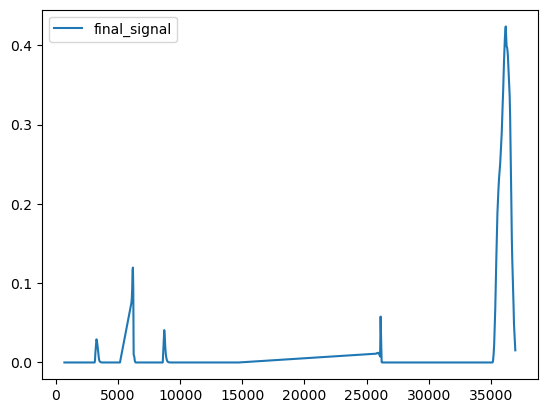

In [366]:
df_pos[df_pos.product_id == 'SOL-USD'][['final_signal']].plot()

In [376]:
df_pos[(df_pos.product_id == 'SOL-USD') & (df_pos['date'] >= pd.Timestamp('2024-01-01'))]

,date,product_id,20_avg_true_range_price,actual_position_notional,actual_position_size,annualized_volatility_30,event,final_signal,final_weighted_additive_signal,highest_high_56,open,stopout_flag,t_1_close,target_notional,target_size,year,month,lag_notional,close,fwd_5d,fwd_10d,fwd_20d
25801,2024-04-01,SOL-USD,14.022973,0.0,0.0,1.032367,No Position,1.113283e-02,0.247554,209.90,202.41,False,202.38,3.884171e+01,1.919246e-01,2024,4,0.0,192.35,-0.070808,-0.103977,-0.226306
25842,2024-04-02,SOL-USD,14.338880,0.0,0.0,1.057224,No Position,1.186910e-02,0.246003,209.90,192.37,False,192.35,3.275813e+01,1.703048e-01,2024,4,0.0,181.54,-0.011072,-0.155889,-0.135067
25883,2024-04-03,SOL-USD,14.544701,0.0,0.0,1.084782,No Position,1.188584e-02,0.226848,209.90,181.58,False,181.54,3.143008e+01,1.731303e-01,2024,4,0.0,185.11,-0.024040,-0.251904,-0.164335
25924,2024-04-04,SOL-USD,14.584253,0.0,0.0,1.084163,No Position,1.220941e-02,0.211140,209.90,185.12,False,185.11,3.264783e+01,1.763699e-01,2024,4,0.0,184.15,-0.064295,-0.177627,-0.197882
25965,2024-04-05,SOL-USD,14.142896,0.0,0.0,1.054935,No Position,1.208034e-02,0.191874,209.90,184.11,False,184.15,3.141417e+01,1.705901e-01,2024,4,0.0,174.46,-0.006420,-0.205778,-0.169838
26006,2024-04-06,SOL-USD,14.436906,0.0,0.0,1.074955,No Position,1.067331e-02,0.158866,209.90,174.46,False,174.46,2.688207e+01,1.540873e-01,2024,4,0.0,178.73,-0.035696,-0.237621,-0.221060
26047,2024-04-07,SOL-USD,13.673391,0.0,0.0,1.026832,No Position,9.128640e-03,0.129432,209.90,178.71,False,178.73,2.369271e+01,1.325615e-01,2024,4,0.0,179.53,-0.146438,-0.265638,-0.213391
26088,2024-04-08,SOL-USD,12.932116,0.0,0.0,1.026926,No Position,7.531236e-03,0.102114,209.90,179.52,False,179.53,1.946907e+01,1.084447e-01,2024,4,0.0,180.66,-0.233477,-0.213218,-0.236245
26129,2024-04-09,SOL-USD,12.591914,0.0,0.0,1.026018,No Position,5.785491e-02,0.075612,209.90,180.65,False,180.66,1.439448e+02,7.967717e-01,2024,4,0.0,172.31,-0.121119,-0.172654,-0.200685
26170,2024-04-10,SOL-USD,12.536494,0.0,0.0,1.043537,No Position,2.930150e-02,0.037198,209.90,172.27,False,172.31,6.511645e+01,3.779029e-01,2024,4,0.0,173.34,-0.200646,-0.126976,-0.269297


In [380]:
df_perf[df_perf.index >= pd.Timestamp('2024-04-01')].head()

,year,month,daily_portfolio_volatility,available_cash,count_of_positions,total_actual_position_notional,total_target_notional,total_portfolio_value,total_portfolio_value_upper_limit,portfolio_daily_pct_returns,portfolio_strategy_cumulative_return,portfolio_rolling_sharpe_50,strategy_cumulative_return,equity_curve,equity_curve_cum_max,drawdown,drawdown_pct,End,Start,equity_curve_DDDuration,profitable_trade
date,,,,,,,,,,,,,,,,,,,,,
2024-04-01,2024,4,0.095138,17479.325578,0.0,0.0,8322.523245,17479.325578,14548.357206,0.021244,0.165288,0.0,0.165288,1.165288,1.171048,-0.00576,-0.004918,2024-04-01,48,202 days,True
2024-04-02,2024,4,0.119934,17479.325578,0.0,0.0,8691.999097,17479.325578,14857.426741,0.000000,0.165288,0.0,0.165288,1.165288,1.171048,-0.00576,-0.004918,2024-04-02,48,202 days,False
2024-04-03,2024,4,0.121998,17479.325578,0.0,0.0,8221.955236,17479.325578,14857.426741,0.000000,0.165288,0.0,0.165288,1.165288,1.171048,-0.00576,-0.004918,2024-04-03,48,202 days,False
2024-04-04,2024,4,0.120713,17479.325578,0.0,0.0,8260.782907,17479.325578,14857.426741,0.000000,0.165288,0.0,0.165288,1.165288,1.171048,-0.00576,-0.004918,2024-04-04,48,202 days,False
2024-04-05,2024,4,0.127567,17479.325578,0.0,0.0,8435.013744,17479.325578,14857.426741,0.000000,0.165288,0.0,0.165288,1.165288,1.171048,-0.00576,-0.004918,2024-04-05,48,202 days,False


In [388]:
df_pos[df_pos['date'] == pd.Timestamp('2024-04-01')][['product_id','final_signal','target_notional','actual_position_notional']].sort_values('final_signal', ascending=False)

,product_id,final_signal,target_notional,actual_position_notional
25794,MKR-USD,3.488667e-01,9.555248e+02,0.0
25778,BTC-USD,3.261671e-01,1.539435e+03,0.0
25777,BCH-USD,2.635800e-01,4.014252e+02,0.0
25785,ETC-USD,1.883437e-01,6.548847e+02,0.0
25804,UNI-USD,1.853826e-01,6.206108e+02,0.0
25773,APT-USD,1.822616e-01,6.835847e+02,0.0
25782,DOGE-USD,1.646432e-01,3.594112e+02,0.0
25806,XTZ-USD,1.472302e-01,5.318370e+02,0.0
25771,ANKR-USD,1.380977e-01,3.465495e+02,0.0
25799,SHIB-USD,1.313740e-01,1.764414e+02,0.0


In [390]:
df_pos[(df_pos['date'] == pd.Timestamp('2024-04-01')) & (df_pos.product_id == 'MKR-USD')]

,date,product_id,20_avg_true_range_price,actual_position_notional,actual_position_size,annualized_volatility_30,event,final_signal,final_weighted_additive_signal,highest_high_56,open,stopout_flag,t_1_close,target_notional,target_size,year,month,lag_notional,close,fwd_5d,fwd_10d,fwd_20d
25794,2024-04-01,MKR-USD,285.351574,0.0,0.0,1.315057,No Position,0.348867,0.48649,4075.0,3921.21,False,3921.12,955.524846,0.243687,2024,4,0.0,3743.46,-0.01006,-0.103177,-0.197723


In [392]:
4075.0 - 1.75 * 285.351574

3575.6347455

## Final Trend Following Signal Analysis

In [322]:
df_pos = pd.read_pickle("/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/expanded_universe/Daily_Positions_R2_Confirm_0-2022-04-01_2024-12-31.pickle")
df_open = pd.read_pickle("/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/expanded_universe/Monthly_Open_Positions_R2_Confirm_0-2022-04-01_2024-12-31.pickle")
df_perf = pd.read_pickle("/Users/adheerchauhan/Documents/git/trend_following/research/backtest_results/expanded_universe/Daily_Performance_R2_Confirm_0-2022-04-01_2024-12-31.pickle")

In [326]:
thresh = 1e-8

# 1) Detect entries (actual_position_notional turns from ~0 to >0)
df_pos['lag_notional'] = df_pos.groupby('product_id')['actual_position_notional'].shift()
entries = df_pos[(df_pos['lag_notional'].fillna(0)<=thresh) & (df_pos['actual_position_notional']>thresh)].copy()

# 2) Reconstruct close and daily returns per product_id
df_pos['close'] = df_pos.groupby('product_id')['t_1_close'].shift(-1)

for h in (5, 10, 20):
    df_pos[f'fwd_{h}d'] = (
        df_pos.groupby('product_id')['close'].shift(-h) / df_pos['close']
        - 1.0
    )

# 4) Attach forward returns at the entry date
fwd_cols = ['fwd_5d','fwd_10d','fwd_20d']
entry_fwd = entries[['date','product_id','final_signal']].merge(
    df_pos[['date','product_id']+fwd_cols], on=['date','product_id'], how='left'
)

# 5) Bucketize by final_signal (tune bins if you later z-score/percentile-rank)
bins = [-np.inf, 0.00, 0.25, 0.50, 0.75, np.inf]
labels = ['<=0','0–0.25','0.25–0.5','0.5–0.75','>0.75']
entry_fwd['signal_bucket_raw_signal'] = pd.cut(entry_fwd['final_signal'], bins=bins, labels=labels)

entry_fwd['signal_prank'] = (
    entry_fwd.groupby('date')['final_signal']
             .rank(pct=True)
)
bins = [0, .2, .4, .6, .8, 1.0]
labels = ['0–20%','20–40%','40–60%','60–80%','80–100%']
entry_fwd['signal_bucket_percentile_ranks'] = pd.cut(entry_fwd['signal_prank'], bins=bins, labels=labels, include_lowest=True)


sig_bucket_summary_raw_signal = entry_fwd.groupby('signal_bucket_raw_signal')[fwd_cols].agg(['mean','median','count'])
sig_bucket_hits_raw_signal    = entry_fwd.groupby('signal_bucket_raw_signal')[fwd_cols].apply(lambda s: (s>0).mean()).add_suffix('_hit')

sig_bucket_summary_percentile_ranks = entry_fwd.groupby('signal_bucket_percentile_ranks')[fwd_cols].agg(['mean','median','count'])
sig_bucket_hits_percentile_ranks    = entry_fwd.groupby('signal_bucket_percentile_ranks')[fwd_cols].apply(lambda s: (s>0).mean()).add_suffix('_hit')


In [273]:
df_pos[df_pos.product_id == 'BCH-USD'][['date','product_id','close', 'fwd_5d', 'fwd_10d', 'fwd_20d']].head(20)

,date,product_id,close,fwd_5d,fwd_10d,fwd_20d
4,2022-04-01,BCH-USD,377.35,-0.122830,-0.218444,-0.163456
26,2022-04-02,BCH-USD,373.15,-0.099317,-0.182661,-0.139247
48,2022-04-03,BCH-USD,378.78,-0.146259,-0.099398,-0.174508
70,2022-04-04,BCH-USD,376.11,-0.133020,-0.102630,-0.182074
92,2022-04-05,BCH-USD,365.33,-0.124216,-0.066734,-0.138970
114,2022-04-06,BCH-USD,331.00,-0.109003,0.035952,-0.104441
136,2022-04-07,BCH-USD,336.09,-0.092535,-0.023535,-0.085751
158,2022-04-08,BCH-USD,323.38,0.054889,0.052879,-0.051982
180,2022-04-09,BCH-USD,326.08,0.035053,0.044590,-0.095713
202,2022-04-10,BCH-USD,319.95,0.065635,0.033130,-0.131646


In [338]:
entry_fwd.groupby(['signal_bucket_raw_signal','signal_bucket_percentile_ranks']).size()

signal_bucket_raw_signal  signal_bucket_percentile_ranks
<=0                       0–20%                              0
                          20–40%                             0
                          40–60%                             0
                          60–80%                             0
                          80–100%                            0
0–0.25                    0–20%                              0
                          20–40%                             0
                          40–60%                             5
                          60–80%                             0
                          80–100%                           41
0.25–0.5                  0–20%                              0
                          20–40%                             0
                          40–60%                             0
                          60–80%                             0
                          80–100%                            

In [328]:
sig_bucket_summary_raw_signal

fwd_5d                   fwd_10d                  \
                              mean    median count      mean    median count   
signal_bucket_raw_signal                                                       
<=0                            NaN       NaN     0       NaN       NaN     0   
0–0.25                    0.024581  0.008890    46  0.046652  0.030748    46   
0.25–0.5                  0.110717  0.068556     8  0.102047  0.122099     8   
0.5–0.75                       NaN       NaN     0       NaN       NaN     0   
>0.75                          NaN       NaN     0       NaN       NaN     0   

                           fwd_20d                  
                              mean    median count  
signal_bucket_raw_signal                            
<=0                            NaN       NaN     0  
0–0.25                    0.084085  0.051514    45  
0.25–0.5                  0.003599  0.073206     7  
0.5–0.75                       NaN       NaN     0  
>0.75                          NaN       NaN     0

In [332]:
sig_bucket_hits_raw_signal

,fwd_5d_hit,fwd_10d_hit,fwd_20d_hit
signal_bucket_raw_signal,,,
<=0,NaN,NaN,NaN
0–0.25,0.565217,0.73913,0.565217
0.25–0.5,1.000000,0.75000,0.500000
0.5–0.75,NaN,NaN,NaN
>0.75,NaN,NaN,NaN


In [330]:
sig_bucket_summary_percentile_ranks

fwd_5d                   fwd_10d            \
                                    mean    median count      mean    median   
signal_bucket_percentile_ranks                                                 
0–20%                                NaN       NaN     0       NaN       NaN   
20–40%                               NaN       NaN     0       NaN       NaN   
40–60%                         -0.017836 -0.019555     5 -0.010691 -0.066022   
60–80%                               NaN       NaN     0       NaN       NaN   
80–100%                         0.042972  0.034651    49  0.061548  0.040498   

                                       fwd_20d                  
                               count      mean    median count  
signal_bucket_percentile_ranks                                  
0–20%                              0       NaN       NaN     0  
20–40%                             0       NaN       NaN     0  
40–60%                             5  0.030887  0.025307     5  
60–80%                             0       NaN       NaN     0  
80–100%                           49  0.077757  0.073206    47

In [334]:
sig_bucket_hits_percentile_ranks

,fwd_5d_hit,fwd_10d_hit,fwd_20d_hit
signal_bucket_percentile_ranks,,,
0–20%,NaN,NaN,NaN
20–40%,NaN,NaN,NaN
40–60%,0.400000,0.40000,0.60000
60–80%,NaN,NaN,NaN
80–100%,0.653061,0.77551,0.55102


In [342]:
df_pos.head()

,date,product_id,20_avg_true_range_price,actual_position_notional,actual_position_size,annualized_volatility_30,event,final_signal,final_weighted_additive_signal,highest_high_56,open,stopout_flag,t_1_close,target_notional,target_size,year,month,lag_notional,close,fwd_5d,fwd_10d,fwd_20d
0,2022-04-01,AAVE-USD,18.364666,0.0,0.0,1.488902,<NA>,0.005122,0.303960,242.15000,207.01000,False,207.00000,0.0,0.0,2022,4,NaN,244.76000,-0.221768,-0.354511,-0.290652
1,2022-04-01,ADA-USD,0.075414,0.0,0.0,0.832059,<NA>,0.054916,0.231736,1.26390,1.14160,False,1.14170,0.0,0.0,2022,4,NaN,1.16540,-0.096877,-0.210743,-0.218981
2,2022-04-01,ALGO-USD,0.060741,0.0,0.0,0.704173,<NA>,0.000000,-0.181632,1.10360,0.92980,False,0.92950,0.0,0.0,2022,4,NaN,0.93900,-0.183600,-0.261448,-0.234611
3,2022-04-01,ANKR-USD,0.006577,0.0,0.0,0.847061,<NA>,0.000024,0.001909,0.09816,0.09521,False,0.09524,0.0,0.0,2022,4,NaN,0.09533,-0.189237,-0.283961,-0.207804
4,2022-04-01,BCH-USD,21.876852,0.0,0.0,0.790876,<NA>,0.002154,0.307267,391.38000,384.21000,False,384.15000,0.0,0.0,2022,4,NaN,377.35000,-0.122830,-0.218444,-0.163456


In [354]:
df_pos.groupby(['product_id']).agg({'actual_position_notional':'sum'}).sort_values('actual_position_notional', ascending=False)#.head(10).index

,actual_position_notional
product_id,
BTC-USD,143977.917933
ETH-USD,131154.007523
LTC-USD,41685.488230
XRP-USD,27274.012367
BCH-USD,20874.885297
ALGO-USD,20361.060739
ADA-USD,17415.919199
XLM-USD,17336.434503
AAVE-USD,8769.410982


## Prod Signal with Top 10 Coins by Notional from Expanded Universe

In [ ]:
expanded_universe_ticker_list_10 = ['BTC-USD', 'ETH-USD', 'LTC-USD', 'XRP-USD', 'BCH-USD', 'ALGO-USD',
                                    'ADA-USD', 'XLM-USD', 'AAVE-USD', 'UNI-USD']


## T-Cost Analysis

In [316]:
df_pos = df_pos.sort_values(['date','product_id'])
df_pos['trade_notional'] = df_pos.groupby('product_id')['actual_position_notional'].diff().fillna(0.0).abs()

# Simple, conservative cost model (bps)
# – replace with your live TC model if you have one
df_pos['cost_bps'] = 127#8 + 35*np.sqrt((df_pos['trade_notional'] / df_pos['trade_notional'].replace(0,np.nan).rolling(30).median()).clip(0,3)).fillna(8)

df_pos['est_cost_usd'] = df_pos['trade_notional'] * df_pos['cost_bps'] / 1e4

# Daily aggregates
daily_traded = df_pos.groupby('date')['trade_notional'].sum().to_frame('traded_notional_usd')
daily_costs  = df_pos.groupby('date')['est_cost_usd'].sum().to_frame('est_cost_usd')

turnover_df = daily_traded.join(daily_costs).join(df_perf[['portfolio_daily_pct_returns']])
turnover_df['net_portfolio_ret_est'] = turnover_df['portfolio_daily_pct_returns'] - (turnover_df['est_cost_usd']/df_perf['total_portfolio_value'])


In [318]:
turnover_df.head(20)

,traded_notional_usd,est_cost_usd,portfolio_daily_pct_returns,net_portfolio_ret_est
date,,,,
2022-04-01,0.000000,0.000000,0.000000,0.000000
2022-04-02,0.000000,0.000000,0.000000,0.000000
2022-04-03,0.000000,0.000000,0.000000,0.000000
2022-04-04,3979.112636,50.534730,-0.003412,-0.006793
2022-04-05,4098.560015,52.051712,-0.011269,-0.014791
2022-04-06,2040.164646,25.910091,0.000015,-0.001738
2022-04-07,1920.717267,24.393109,-0.011817,-0.013487
2022-04-08,0.000000,0.000000,0.000000,0.000000
2022-04-09,0.000000,0.000000,0.000000,0.000000


In [314]:
perf.estimate_fee_per_trade(passive_trade_rate=passive_trade_rate) + transaction_cost_est

0.0127

<Axes: xlabel='date'>

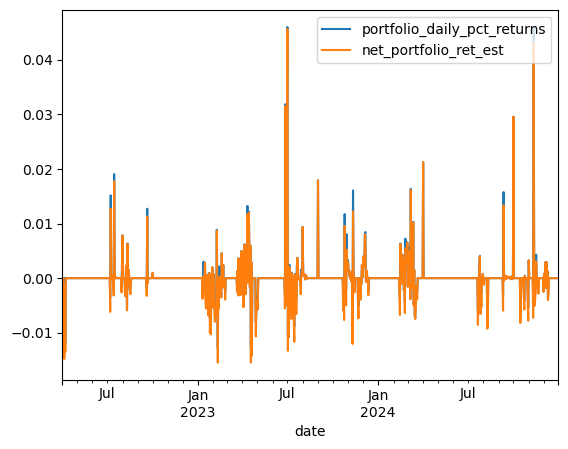

In [320]:
turnover_df[['portfolio_daily_pct_returns','net_portfolio_ret_est']].plot()

<Axes: xlabel='date'>

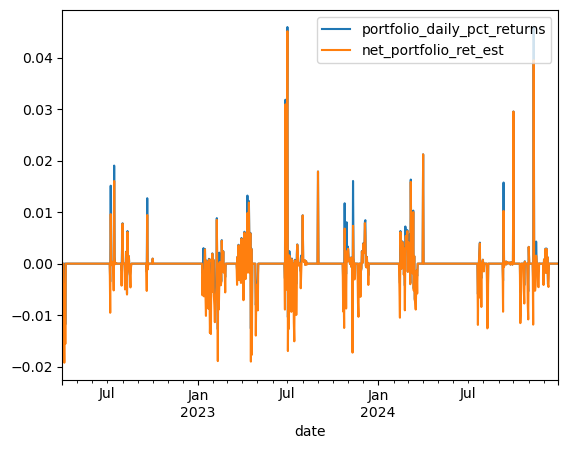

In [308]:
turnover_df[['portfolio_daily_pct_returns','net_portfolio_ret_est']].plot()

In [302]:
df_pos[df_pos.trade_notional != 0].head()

,date,product_id,20_avg_true_range_price,actual_position_notional,actual_position_size,annualized_volatility_30,event,final_signal,final_weighted_additive_signal,highest_high_56,open,stopout_flag,t_1_close,target_notional,target_size,year,month,lag_notional,close,fwd_5d,fwd_10d,fwd_20d,trade_notional,cost_bps,est_cost_usd
78,2022-04-04,ICP-USD,1.731052,2164.704019,95.571921,0.794165,New Long Position,0.091205,0.374618,24.6700,22.6500,False,22.6400,2192.549396,96.844055,2022,4,0.000000,21.8800,-0.159506,-0.246344,-0.259598,2164.704019,288.0,62.343476
83,2022-04-04,UNI-USD,0.799791,1814.408618,152.856665,0.718156,New Long Position,0.069129,0.160027,12.9400,11.8700,False,11.8800,1837.748017,154.692594,2022,4,0.000000,11.5600,-0.129758,-0.180796,-0.246540,1814.408618,288.0,52.254968
100,2022-04-05,ICP-USD,1.829999,-73.590379,-3.363363,0.807826,Trim Long Position,0.079577,0.402736,24.6700,21.8800,False,21.8800,2048.788502,93.637500,2022,4,2164.704019,21.0600,-0.175689,-0.202279,-0.233618,2238.294398,288.0,64.462879
105,2022-04-05,UNI-USD,0.830287,-45.857000,-3.963440,0.728535,Trim Long Position,0.072887,0.196359,12.9400,11.5700,False,11.5600,2080.787769,179.998942,2022,4,1814.408618,11.1200,-0.113309,-0.120504,-0.214029,1860.265617,288.0,53.575650
117,2022-04-06,DOGE-USD,0.011996,1920.717267,11115.261963,0.818129,New Long Position,0.055061,0.414909,0.1801,0.1728,False,0.1728,1945.424154,11258.241632,2022,4,0.000000,0.1434,-0.064156,0.001395,-0.039749,1920.717267,288.0,55.316657


In [45]:
df_perf.head()

,year,month,daily_portfolio_volatility,available_cash,count_of_positions,total_actual_position_notional,total_target_notional,total_portfolio_value,total_portfolio_value_upper_limit,portfolio_daily_pct_returns,portfolio_strategy_cumulative_return,portfolio_rolling_sharpe_50,strategy_cumulative_return,equity_curve,equity_curve_cum_max,drawdown,drawdown_pct,End,Start,equity_curve_DDDuration,profitable_trade
date,,,,,,,,,,,,,,,,,,,,,
2022-04-01,2022,4,0.000000,15000.000000,0.0,0.000000,0.000000,15000.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.0,0.000000,0.000000,2022-04-01,1,104 days,False
2022-04-02,2022,4,0.015734,15000.000000,0.0,0.000000,8348.639555,15000.000000,12750.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.0,0.000000,0.000000,2022-04-02,1,104 days,False
2022-04-03,2022,4,0.016272,15000.000000,0.0,0.000000,8325.288678,15000.000000,12750.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.0,0.000000,0.000000,2022-04-03,1,104 days,False
2022-04-04,2022,4,0.015730,10969.702587,2.0,3979.112636,8884.381908,14948.815223,12750.000000,-0.003412,-0.003412,0.0,-0.003412,0.996588,1.0,-0.003412,-0.003412,2022-04-04,1,104 days,False
2022-04-05,2022,4,0.014390,14780.350095,2.0,-119.447379,8811.302026,14780.350095,12706.492939,-0.011269,-0.014643,0.0,-0.014643,0.985357,1.0,-0.014643,-0.014643,2022-04-05,1,104 days,False


In [47]:
df_perf.reset_index().groupby(['date']).agg({'count_of_positions':'sum','total_actual_position_notional':'sum'}).sort_values('count_of_positions', ascending=False)

,count_of_positions,total_actual_position_notional
date,,
2023-11-14,3.0,-2.727166
2023-10-31,3.0,346.621340
2022-04-06,3.0,1920.717267
2024-11-14,3.0,0.000000
2024-11-12,3.0,2004.725917
2023-04-16,2.0,6273.730613
2023-11-05,2.0,315.200382
2023-11-06,2.0,329.032555
2024-03-13,2.0,3711.929097


<Axes: xlabel='date'>

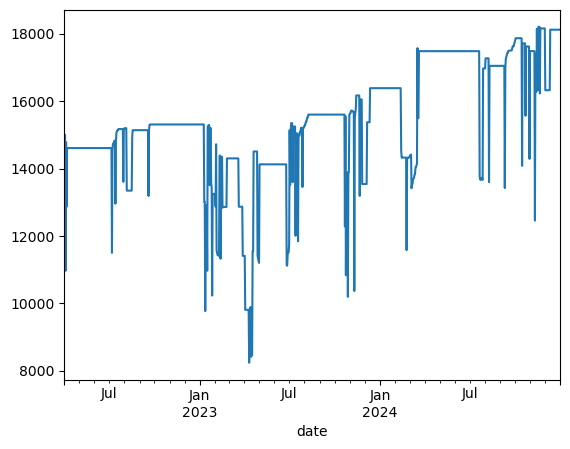

In [49]:
df_perf['available_cash'].plot()

<Axes: xlabel='date'>

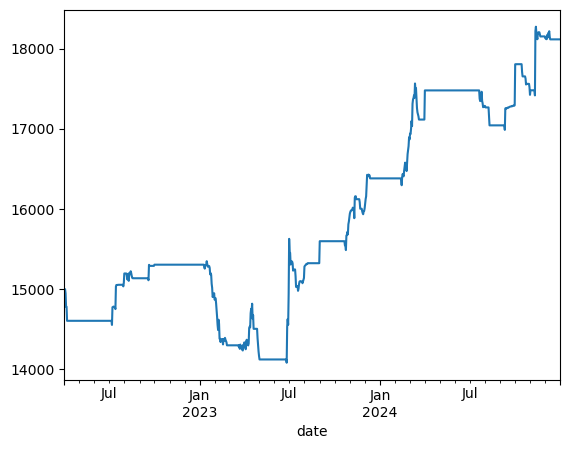

In [51]:
df_perf['total_portfolio_value'].plot()

<Axes: xlabel='date'>

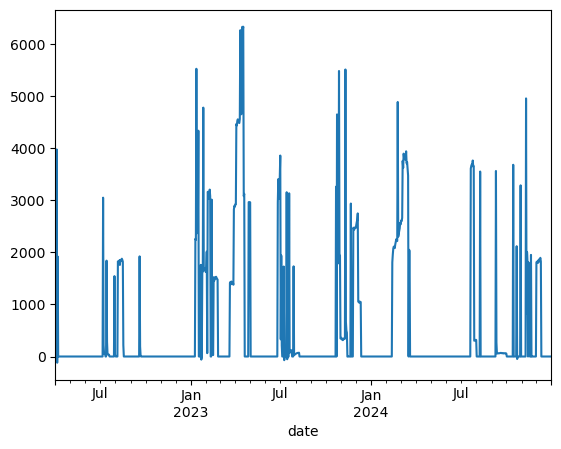

In [53]:
df_perf['total_actual_position_notional'].plot()

In [53]:
df_pos.head()#[df_pos.event != 'No Position'].groupby(['date']).agg({'product_id':'nunique'})

,date,product_id,20_avg_true_range_price,actual_position_notional,actual_position_size,annualized_volatility_30,event,final_signal,final_weighted_additive_signal,highest_high_56,open,stopout_flag,t_1_close,target_notional,target_size,year,month
0,2022-04-01,AAVE-USD,18.364666,0.0,0.0,1.488902,<NA>,0.005122,0.303960,242.15000,207.01000,False,207.00000,0.0,0.0,2022,4
1,2022-04-01,ADA-USD,0.075414,0.0,0.0,0.832059,<NA>,0.054916,0.231736,1.26390,1.14160,False,1.14170,0.0,0.0,2022,4
2,2022-04-01,ALGO-USD,0.060741,0.0,0.0,0.704173,<NA>,0.000000,-0.181632,1.10360,0.92980,False,0.92950,0.0,0.0,2022,4
3,2022-04-01,ANKR-USD,0.006577,0.0,0.0,0.847061,<NA>,0.000024,0.001909,0.09816,0.09521,False,0.09524,0.0,0.0,2022,4
4,2022-04-01,BCH-USD,21.876852,0.0,0.0,0.790876,<NA>,0.002154,0.307267,391.38000,384.21000,False,384.15000,0.0,0.0,2022,4


In [55]:
df_pos.groupby(['product_id']).agg({'actual_position_notional':'sum'}).sort_values('actual_position_notional', ascending=False)

,actual_position_notional
product_id,
BTC-USD,143977.917933
ETH-USD,131154.007523
LTC-USD,41685.488230
XRP-USD,27274.012367
BCH-USD,20874.885297
ALGO-USD,20361.060739
ADA-USD,17415.919199
XLM-USD,17336.434503
AAVE-USD,8769.410982


<Axes: >

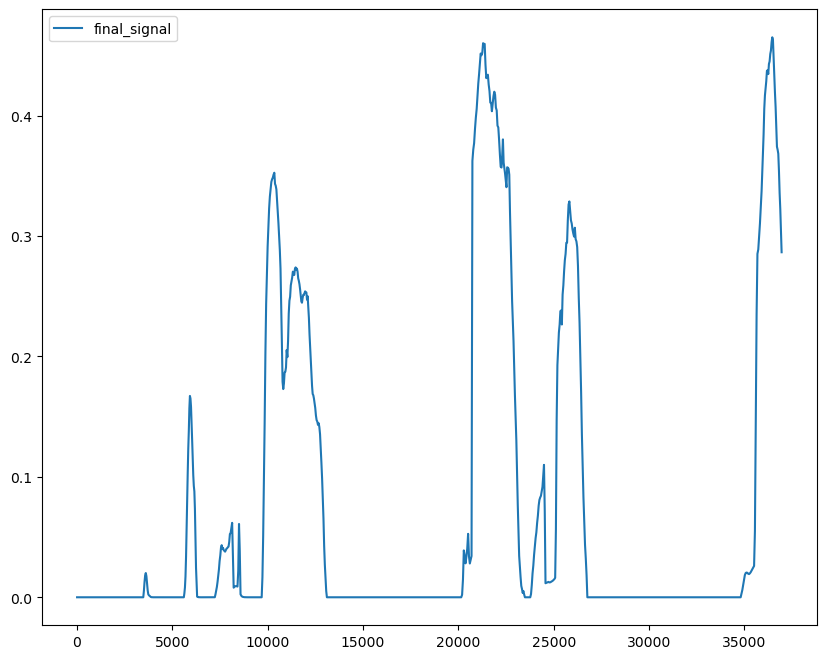

In [65]:
df_pos[df_pos.product_id == 'BTC-USD'][['final_signal']].plot(figsize=(10,8))#.head(20)

<Axes: >

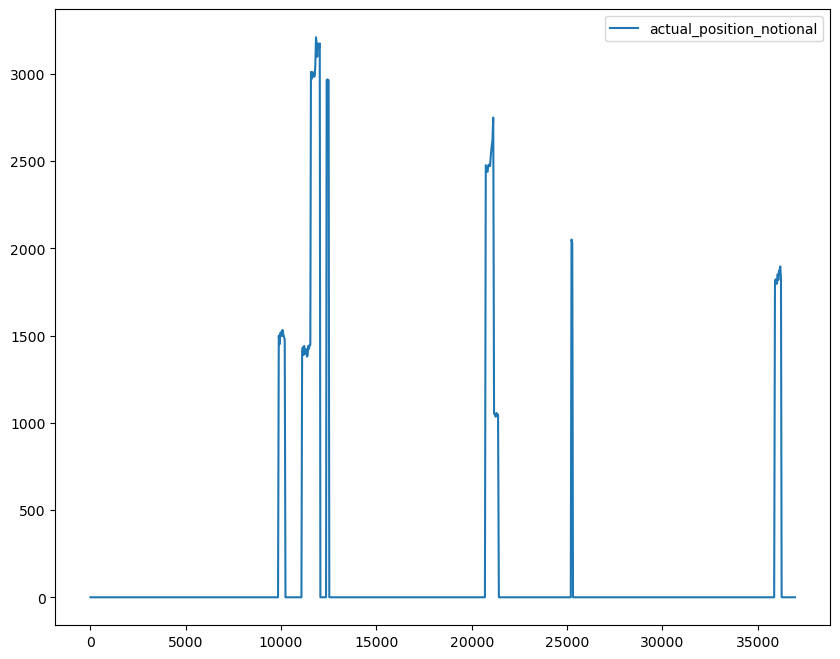

In [67]:
df_pos[df_pos.product_id == 'BTC-USD'][['actual_position_notional']].plot(figsize=(10,8))#.head(20)

In [61]:
df_pos[df_pos.product_id == 'BTC-USD'][['final_signal','actual_position_notional']]#.head(20)

,final_signal,actual_position_notional
5,2.064308e-07,0.000000
27,2.334715e-07,0.000000
49,1.746705e-07,0.000000
71,1.419571e-07,0.000000
93,9.146218e-08,0.000000
115,6.347360e-08,0.000000
137,3.195036e-08,0.000000
159,1.631048e-08,0.000000
181,8.095538e-09,0.000000
203,4.089983e-09,0.000000


In [73]:
signal_bins = [-np.inf, 0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
df_pos['final_signal_bins'] = pd.cut(df_pos['final_signal'], bins=signal_bins)

In [85]:
thresh = 1e-8

# 1) Detect entries (actual_position_notional turns from ~0 to >0)
df_pos['lag_notional'] = df_pos.groupby('product_id')['actual_position_notional'].shift()
entries = df_pos[(df_pos['lag_notional'].fillna(0) <= thresh) & (df_pos['actual_position_notional'] > thresh)].copy()

# 2) Reconstruct close and daily returns per product_id
df_pos['close'] = df_pos.groupby('product_id')['t_1_close'].shift(-1)
df_pos['ret']   = df_pos.groupby('product_id')['close'].pct_change()

In [89]:
df_pos.groupby(['final_signal_bins']).agg({'actual_position_notional':'sum', 'ret': ['median','mean']})

actual_position_notional       ret          
                                       sum    median      mean
final_signal_bins                                             
(-inf, 0.0001]                26802.527342  0.000000  0.001576
(0.0001, 0.001]               30256.722687  0.001786  0.003493
(0.001, 0.005]                 6045.468382 -0.000854  0.005737
(0.005, 0.01]                  3761.793916 -0.002368 -0.000810
(0.01, 0.05]                  22128.551167  0.000960  0.001599
(0.05, 0.1]                   56713.368750  0.001860  0.002608
(0.1, 0.5]                   365344.577954 -0.001729 -0.000854
(0.5, 1.0]                        0.000000       NaN       NaN

In [137]:
df_pos[df_pos.final_signal > 0.09].groupby(['final_signal_bins','product_id']).agg({'actual_position_notional':'sum', 'ret': ['median','mean']}).dropna()

actual_position_notional       ret          
                                                  sum    median      mean
final_signal_bins product_id                                             
(0.05, 0.1]       AAVE-USD                   0.000000 -0.034617  0.001233
                  ACH-USD                    0.000000  0.089040  0.055174
                  ADA-USD                 3638.643877  0.005527  0.006814
                  ALGO-USD                5418.215214  0.006363  0.009130
                  AMP-USD                    0.000000  0.015196  0.020781
                  APT-USD                    0.000000 -0.009671 -0.009671
                  ARB-USD                    0.000000 -0.064871 -0.093442
                  ATOM-USD                   0.000000  0.008609 -0.013849
                  AVAX-USD                   0.000000  0.026464  0.047764
                  AXS-USD                    0.000000  0.023041  0.032391
                  BCH-USD                    0.000000 -0.000782 -0.003376
                  BTC-USD                    0.000000  0.010949  0.013249
                  CBETH-USD                -13.816357 -0.017571  0.004868
                  CHZ-USD                    0.000000  0.023397  0.023397
                  COMP-USD                   0.000000 -0.016347 -0.001268
                  CRO-USD                    0.000000 -0.005893 -0.005147
                  CRV-USD                    0.000000 -0.001332 -0.015602
                  DASH-USD                 -39.732753  0.018476  0.018476
                  DOGE-USD                   0.000000 -0.012963 -0.012963
                  DOT-USD                    0.000000  0.051255  0.051255
                  ENS-USD                    0.000000  0.046188  0.046188
                  EOS-USD                    0.000000 -0.006845 -0.003172
                  ETC-USD                    0.000000 -0.006897  0.011427
                  ETH-USD                 3626.575992 -0.006635  0.008246
                  FIL-USD                    0.000000 -0.014634 -0.025334
                  FLOW-USD                   0.000000  0.018561  0.018561
                  GRT-USD                    0.000000 -0.010774 -0.010774
                  HBAR-USD                   0.000000  0.015920  0.015920
                  ICP-USD                 2164.704019  0.022594  0.016759
                  JASMY-USD                  0.000000  0.000000  0.000000
                  LINK-USD                   0.000000 -0.051965 -0.051965
                  LRC-USD                    0.000000  0.011884  0.011884
                  LTC-USD                    0.000000 -0.012589 -0.007828
                  MANA-USD                   0.000000  0.076713  0.076713
                  MASK-USD                   0.000000  0.000000  0.000000
                  MKR-USD                   23.693506  0.026477  0.026262
                  MSOL-USD                   0.000000  0.011466  0.011466
                  QNT-USD                    0.000000 -0.057528 -0.057528
                  ROSE-USD                   0.000000 -0.026489 -0.042992
                  SAND-USD                   0.000000  0.033569  0.033569
                  SHIB-USD                   0.000000 -0.024310 -0.020433
                  SNX-USD                    0.000000 -0.053623 -0.053623
                  SOL-USD                    0.000000 -0.045968 -0.053752
                  SPELL-USD                  0.000000  0.004897  0.004897
                  SUSHI-USD                  0.000000  0.027535  0.021394
                  UMA-USD                    0.000000 -0.001775  0.000482
                  UNI-USD                    0.000000 -0.009652 -0.009652
                  VET-USD                    0.000000 -0.105786 -0.105786
                  XLM-USD                    0.000000 -0.000529 -0.004255
                  XRP-USD                    0.000000  0.009566  0.009566
                  XTZ-USD                    0.000000 -0.003497 -0.000676
                  YFI-USD        

In [119]:
df_perf[df_perf.index >= pd.Timestamp('2022-07-06')].head(20)

,year,month,daily_portfolio_volatility,available_cash,count_of_positions,total_actual_position_notional,total_target_notional,total_portfolio_value,total_portfolio_value_upper_limit,portfolio_daily_pct_returns,portfolio_strategy_cumulative_return,portfolio_rolling_sharpe_50,strategy_cumulative_return,equity_curve,equity_curve_cum_max,drawdown,drawdown_pct,End,Start,equity_curve_DDDuration,profitable_trade
date,,,,,,,,,,,,,,,,,,,,,
2022-07-06,2022,7,0.000332,14605.905299,0.0,0.000000,3997.579413,14605.905299,12415.019504,0.000000,-0.026273,0.0,-0.026273,0.973727,1.000000,-0.026273,-0.026273,2022-07-06,1,104 days,False
2022-07-07,2022,7,0.001658,11502.150423,1.0,3052.529165,4033.520587,14554.679587,12415.019504,-0.003507,-0.029688,0.0,-0.029688,0.970312,1.000000,-0.029688,-0.029688,2022-07-07,1,104 days,False
2022-07-08,2022,7,0.002786,14554.679587,1.0,220.527093,3975.673011,14775.206680,12371.477649,0.015152,-0.014986,0.0,-0.014986,0.985014,1.000000,-0.014986,-0.014986,2022-07-08,1,104 days,True
2022-07-09,2022,7,0.003087,14726.621618,1.0,50.971636,4048.509098,14777.593254,12558.925678,0.000162,-0.014827,0.0,-0.014827,0.985173,1.000000,-0.014827,-0.014827,2022-07-09,1,104 days,True
2022-07-10,2022,7,0.004701,14728.595334,1.0,54.780749,3914.858385,14783.376083,12560.954266,0.000391,-0.014442,0.0,-0.014442,0.985558,1.000000,-0.014442,-0.014442,2022-07-10,1,104 days,True
2022-07-11,2022,7,0.005852,14780.910526,1.0,48.111301,3982.429800,14780.910526,12565.869671,-0.000167,-0.014606,0.0,-0.014606,0.985394,1.000000,-0.014606,-0.014606,2022-07-11,1,104 days,False
2022-07-12,2022,7,0.006824,14824.288179,1.0,0.000000,4069.663890,14776.176878,12563.773947,-0.000320,-0.014922,0.0,-0.014922,0.985078,1.000000,-0.014922,-0.014922,2022-07-12,1,104 days,False
2022-07-13,2022,7,0.007829,14824.288179,0.0,0.000000,4576.980790,14776.176878,12559.750346,0.000000,-0.014922,0.0,-0.014922,0.985078,1.000000,-0.014922,-0.014922,2022-07-13,1,104 days,False
2022-07-14,2022,7,0.008738,12958.251834,1.0,1842.337683,4749.053279,14752.478216,12559.750346,-0.001604,-0.016501,0.0,-0.016501,0.983499,1.000000,-0.016501,-0.016501,2022-07-14,1,104 days,False


In [127]:
df_pos[(df_pos.date > pd.Timestamp('2022-07-05')) & (df_pos.event != 'No Position')].head(20)

,date,product_id,20_avg_true_range_price,actual_position_notional,actual_position_size,annualized_volatility_30,event,final_signal,final_weighted_additive_signal,highest_high_56,open,stopout_flag,t_1_close,target_notional,target_size,year,month,final_signal_bins,lag_notional,close,ret
2536,2022-07-07,UNI-USD,0.502562,3052.529165,571.313712,1.385082,New Long Position,0.031682,0.041362,6.077,5.343,False,5.348,4033.520587,754.211030,2022,7,"(0.01, 0.05]",0.000000,5.728,0.071055
2565,2022-07-08,UNI-USD,0.506699,220.527093,38.493121,1.400308,Trim Long Position,0.053219,0.083845,6.077,5.729,False,5.728,3975.673011,694.076992,2022,7,"(0.05, 0.1]",3052.529165,5.791,0.010999
2594,2022-07-09,UNI-USD,0.500728,50.971636,8.801871,1.395950,Trim Long Position,0.058973,0.126510,6.077,5.791,False,5.791,4048.509098,699.103626,2022,7,"(0.05, 0.1]",220.527093,6.448,0.113452
2623,2022-07-10,UNI-USD,0.531992,54.780749,8.495774,1.443840,Trim Long Position,0.089810,0.175858,6.620,6.448,False,6.448,3914.858385,607.143050,2022,7,"(0.05, 0.1]",50.971636,6.234,-0.033189
2652,2022-07-11,UNI-USD,0.528183,48.111301,7.713853,1.419897,Trim Long Position,0.111805,0.219396,6.620,6.237,False,6.234,3982.429800,638.824158,2022,7,"(0.1, 0.5]",54.780749,5.561,-0.107956
2681,2022-07-12,UNI-USD,0.575975,0.000000,0.000000,1.439064,Close Long Position,0.125037,0.245132,6.620,5.560,True,5.561,3767.962436,677.569221,2022,7,"(0.1, 0.5]",48.111301,5.528,-0.005934
2710,2022-07-13,UNI-USD,0.562549,0.000000,0.000000,1.406747,Stop-Loss Cooldown,0.122121,0.265487,6.620,5.531,True,5.528,3280.197440,593.378698,2022,7,"(0.1, 0.5]",0.000000,6.118,0.106729
2737,2022-07-14,QNT-USD,9.330814,1842.337683,21.779616,1.283802,New Long Position,0.070755,0.125434,90.580,84.590,False,84.780,1866.036344,22.010337,2022,7,"(0.05, 0.1]",0.000000,97.540,0.150507
2739,2022-07-14,UNI-USD,0.604592,0.000000,0.000000,1.385929,Stop-Loss Cooldown,0.118013,0.294027,6.620,6.114,True,6.118,2883.016935,471.235197,2022,7,"(0.1, 0.5]",0.000000,7.013,0.146290
2766,2022-07-15,QNT-USD,10.027879,281.174837,2.883844,1.343532,Trim Long Position,0.085374,0.188082,99.250,97.500,False,97.540,2090.279163,21.429969,2022,7,"(0.05, 0.1]",1842.337683,104.420,0.070535


In [97]:
df_pos[(df_pos.final_signal > 0.1) & (df_pos.product_id == 'UNI-USD')].head(20)

,date,product_id,20_avg_true_range_price,actual_position_notional,actual_position_size,annualized_volatility_30,event,final_signal,final_weighted_additive_signal,highest_high_56,open,stopout_flag,t_1_close,target_notional,target_size,year,month,final_signal_bins,lag_notional,close,ret
2652,2022-07-11,UNI-USD,0.528183,48.111301,7.713853,1.419897,Trim Long Position,0.111805,0.219396,6.620,6.237,False,6.234,3982.429800,638.824158,2022,7,"(0.1, 0.5]",54.780749,5.561,-0.107956
2681,2022-07-12,UNI-USD,0.575975,0.000000,0.000000,1.439064,Close Long Position,0.125037,0.245132,6.620,5.560,True,5.561,3767.962436,677.569221,2022,7,"(0.1, 0.5]",48.111301,5.528,-0.005934
2710,2022-07-13,UNI-USD,0.562549,0.000000,0.000000,1.406747,Stop-Loss Cooldown,0.122121,0.265487,6.620,5.531,True,5.528,3280.197440,593.378698,2022,7,"(0.1, 0.5]",0.000000,6.118,0.106729
2739,2022-07-14,UNI-USD,0.604592,0.000000,0.000000,1.385929,Stop-Loss Cooldown,0.118013,0.294027,6.620,6.114,True,6.118,2883.016935,471.235197,2022,7,"(0.1, 0.5]",0.000000,7.013,0.146290
2768,2022-07-15,UNI-USD,0.650155,0.000000,0.000000,1.450707,Stop-Loss Cooldown,0.105933,0.329126,7.107,7.014,True,7.013,2402.026033,342.510485,2022,7,"(0.1, 0.5]",0.000000,6.781,-0.033081
3924,2022-08-21,UNI-USD,0.721817,0.000000,0.000000,1.196941,No Position,0.163712,0.440999,9.840,7.014,False,7.009,3680.782959,525.150943,2022,8,"(0.1, 0.5]",0.000000,7.211,0.028820
3957,2022-08-22,UNI-USD,0.685929,0.000000,0.000000,1.188573,No Position,0.172065,0.436801,9.840,7.209,False,7.211,3754.165018,520.616422,2022,8,"(0.1, 0.5]",0.000000,6.983,-0.031618
3990,2022-08-23,UNI-USD,0.689365,0.000000,0.000000,1.194380,No Position,0.169650,0.429536,9.840,6.985,False,6.983,3777.748073,540.992134,2022,8,"(0.1, 0.5]",0.000000,7.109,0.018044
4023,2022-08-24,UNI-USD,0.667425,0.000000,0.000000,1.187610,No Position,0.170251,0.425210,9.840,7.118,False,7.109,3772.146654,530.615650,2022,8,"(0.1, 0.5]",0.000000,7.045,-0.009003
4056,2022-08-25,UNI-USD,0.643385,0.000000,0.000000,1.183594,No Position,0.167714,0.419249,9.840,7.048,False,7.045,3783.439713,537.038994,2022,8,"(0.1, 0.5]",0.000000,7.023,-0.003123


In [135]:
ranks = df_pos['final_signal'].rank(method='first')
df_pos['final_signal_quantiles'] = pd.qcut(ranks, q=7)


In [137]:
df_pos.shape

(36974, 18)

In [143]:
df_pos.groupby(['final_signal_quantiles']).agg({'final_signal': ['median', 'mean'], 'actual_position_notional': 'sum'})

final_signal               actual_position_notional
                              median          mean                      sum
final_signal_quantiles                                                     
(0.999, 5282.857]       0.000000e+00  0.000000e+00                 0.000000
(5282.857, 10564.714]   0.000000e+00  0.000000e+00                 0.000000
(10564.714, 15846.571]  0.000000e+00  0.000000e+00                 0.000000
(15846.571, 21128.429]  1.227889e-31  9.185891e-17                 0.000000
(21128.429, 26410.286]  1.213337e-09  3.418936e-07              5237.299372
(26410.286, 31692.143]  5.045987e-03  1.291751e-02             92983.437288
(31692.143, 36974.0]    1.973841e-01  2.190911e-01            412832.273538

In [85]:
df_pos[df_pos.product_id == 'BTC-USD']['final_signal'].describe()

count    1.006000e+03
mean     7.121833e-02
std      1.297786e-01
min      0.000000e+00
25%      0.000000e+00
50%      2.048826e-15
75%      6.011122e-02
max      4.650698e-01
Name: final_signal, dtype: float64

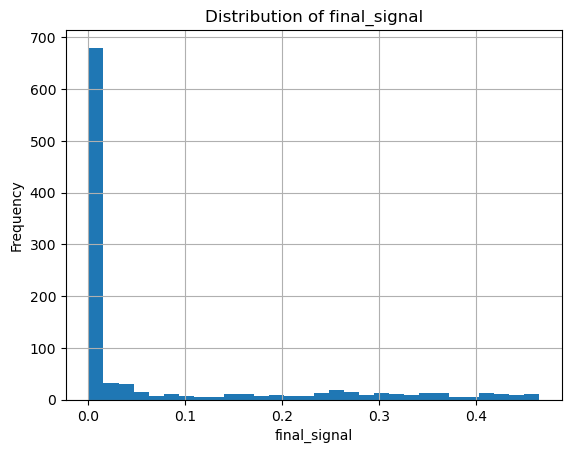

In [87]:
import matplotlib.pyplot as plt

df_pos[df_pos.product_id == 'BTC-USD']['final_signal'].hist(bins=30)  # adjust bins as needed
plt.xlabel('final_signal')
plt.ylabel('Frequency')
plt.title('Distribution of final_signal')
plt.show()


In [57]:
df_open

,date,ticker,actual_position_size,actual_position_notional,available_cash,total_portfolio_value,year,month
0,2022-04-30,None,0.000000,0.000000,14605.905299,14605.905299,2022,4
1,2022-05-31,None,0.000000,0.000000,14605.905299,14605.905299,2022,5
2,2022-06-30,None,0.000000,0.000000,14605.905299,14605.905299,2022,6
3,2022-07-31,ICP-USD,5.166898,42.771578,15149.947867,15078.141726,2022,7
4,2022-08-31,None,0.000000,0.000000,15136.701461,15136.701461,2022,8
5,2022-09-30,None,0.000000,0.000000,15305.932364,15291.073616,2022,9
6,2022-10-31,None,0.000000,0.000000,15305.932364,15305.932364,2022,10
7,2022-11-30,None,0.000000,0.000000,15305.932364,15305.932364,2022,11
8,2022-12-31,None,0.000000,0.000000,15305.932364,15305.932364,2022,12
9,2023-01-31,LTC-USD,0.000000,0.000000,13246.814362,14870.188064,2023,1


In [ ]:
df_perf[df_perf.index >= pd.Timestamp('2022-07-30')].head()

In [ ]:
df_pos[(df_pos.date >= pd.Timestamp('2022-07-30')) & (df_pos.product_id == 'ICP-USD')].head()

In [ ]:
df_pos[(df_pos.date >= pd.Timestamp('2024-11-20')) & (df_pos.product_id == 'BTC-USD')].head(20)

In [59]:
df_pos.groupby(['event']).size()

event
Add Long Position          15
Close Long Position        32
Close Short Position       22
New Long Position          54
No Position             36206
Open Long Position        146
Stop-Loss Cooldown        318
Trim Long Position        159
dtype: int64

In [63]:
df_pos[df_pos.event == 'Stop-Loss Cooldown']

,date,product_id,20_avg_true_range_price,actual_position_notional,actual_position_size,annualized_volatility_30,event,final_signal,final_weighted_additive_signal,highest_high_56,open,stopout_flag,t_1_close,target_notional,target_size,year,month
144,2022-04-07,ICP-USD,1.912358,0.0,0.0,0.889143,Stop-Loss Cooldown,5.314903e-02,0.426069,23.510000,18.720000,True,18.730000,2365.566407,1.262983e+02,2022,4
149,2022-04-07,UNI-USD,0.867197,0.0,0.0,0.808455,Stop-Loss Cooldown,6.037622e-02,0.227301,12.500000,9.950000,True,9.950000,2955.433669,2.970285e+02,2022,4
161,2022-04-08,DOGE-USD,0.013488,0.0,0.0,1.028206,Stop-Loss Cooldown,1.840945e-03,0.447238,0.180100,0.145900,True,0.146000,82.377919,5.642323e+02,2022,4
166,2022-04-08,ICP-USD,1.841657,0.0,0.0,0.889960,Stop-Loss Cooldown,4.580039e-02,0.433948,23.510000,19.270000,True,19.290000,2367.821154,1.227486e+02,2022,4
171,2022-04-08,UNI-USD,0.854130,0.0,0.0,0.799852,Stop-Loss Cooldown,5.296656e-02,0.241387,12.500000,10.440000,True,10.450000,3046.786670,2.915585e+02,2022,4
183,2022-04-09,DOGE-USD,0.013432,0.0,0.0,1.028359,Stop-Loss Cooldown,9.332241e-04,0.453433,0.180100,0.142400,True,0.142600,52.068651,3.651378e+02,2022,4
188,2022-04-09,ICP-USD,1.840547,0.0,0.0,0.917731,Stop-Loss Cooldown,4.356680e-02,0.432104,23.510000,17.990000,True,18.000000,2723.801207,1.513223e+02,2022,4
193,2022-04-09,UNI-USD,0.861356,0.0,0.0,0.827055,Stop-Loss Cooldown,3.636803e-02,0.241959,12.500000,9.730000,True,9.740000,2523.019402,2.590369e+02,2022,4
205,2022-04-10,DOGE-USD,0.012543,0.0,0.0,1.014823,Stop-Loss Cooldown,4.732698e-04,0.459903,0.180100,0.144300,True,0.144300,33.059728,2.291041e+02,2022,4
210,2022-04-10,ICP-USD,1.725257,0.0,0.0,0.901410,Stop-Loss Cooldown,4.218873e-02,0.432781,23.510000,18.400000,True,18.390000,3317.836567,1.804153e+02,2022,4


In [ ]:
df_pos[(df_pos.date >= pd.Timestamp('2022-04-04')) & (df_pos.product_id == 'ICP-USD')].head(20)

In [65]:
df_perf.head()

,year,month,daily_portfolio_volatility,available_cash,count_of_positions,total_actual_position_notional,total_target_notional,total_portfolio_value,total_portfolio_value_upper_limit
date,,,,,,,,,
2022-04-01,2022,4,0.000000,15000.000000,0.0,0.000000,0.000000,15000.000000,0.000000
2022-04-02,2022,4,0.015734,15000.000000,0.0,0.000000,8348.639555,15000.000000,12750.000000
2022-04-03,2022,4,0.016272,15000.000000,0.0,0.000000,8325.288678,15000.000000,12750.000000
2022-04-04,2022,4,0.015730,10969.702587,2.0,3979.112636,8884.381908,14948.815223,12750.000000
2022-04-05,2022,4,0.014390,14780.350095,2.0,-119.447379,8811.302026,14780.350095,12706.492939


In [67]:
df_perf = size_bin.calculate_portfolio_returns(df_perf, rolling_sharpe_window=50)

In [69]:
df_perf.head()

,year,month,daily_portfolio_volatility,available_cash,count_of_positions,total_actual_position_notional,total_target_notional,total_portfolio_value,total_portfolio_value_upper_limit,portfolio_daily_pct_returns,portfolio_strategy_cumulative_return,portfolio_rolling_sharpe_50
date,,,,,,,,,,,,
2022-04-01,2022,4,0.000000,15000.000000,0.0,0.000000,0.000000,15000.000000,0.000000,0.000000,0.000000,NaN
2022-04-02,2022,4,0.015734,15000.000000,0.0,0.000000,8348.639555,15000.000000,12750.000000,0.000000,0.000000,NaN
2022-04-03,2022,4,0.016272,15000.000000,0.0,0.000000,8325.288678,15000.000000,12750.000000,0.000000,0.000000,NaN
2022-04-04,2022,4,0.015730,10969.702587,2.0,3979.112636,8884.381908,14948.815223,12750.000000,-0.003412,-0.003412,NaN
2022-04-05,2022,4,0.014390,14780.350095,2.0,-119.447379,8811.302026,14780.350095,12706.492939,-0.011269,-0.014643,NaN


<Axes: xlabel='date'>

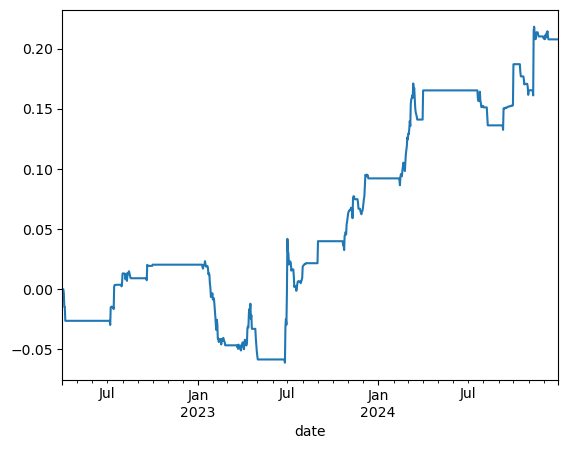

In [71]:
df_perf['portfolio_strategy_cumulative_return'].plot()

In [73]:
print('Calculating In Sample Asset Returns!!')
# df_final_prod_config_backtested = perf.calculate_asset_level_returns(df_final_prod_config_backtested, end_date, ticker_list)

portfolio_perf_metrics_prod_config = calculate_risk_and_performance_metrics(df_perf, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                           strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_prod_config

Calculating In Sample Asset Returns!!


{'annualized_return': 0.07087934649792982,
 'annualized_sharpe_ratio': 0.31628470753028803,
 'calmar_ratio': 0.8592680470900336,
 'annualized_std_dev': 0.1293383111274503,
 'max_drawdown': -0.08248805100802628,
 'max_drawdown_duration': Timedelta('202 days 00:00:00'),
 'hit_rate': 0.15606361829025844,
 't_statistic': 1.6846436375564775,
 'p_value': 0.09236782920460321,
 'trade_count': 282.0}